In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nuclear-test-counts/number-of-nuclear-weapons-tests-for-selected-nuclear-powers-1945-1998.csv
/kaggle/input/ufo-sightings/scrubbed.csv
/kaggle/input/ufo-sightings/complete.csv


# Loading Data

A somewhat clean file, scrubbed.csv, of UFO sightings comes from Kaggle: https://www.kaggle.com/NUFORC/ufo-sightings

Counts of nuclear weapons testing by year and country in the file nuclear-test-counts/number-of-nuclear-weapons-tests-for-selected-nuclear-powers-1945-1998.csv comes from https://ourworldindata.org/grapher/number-of-nuclear-weapons-tests-for-selected-nuclear-powers-1945-1998?stackMode=absolute Click "Data" tab at the bottom of the graph to get the file.

In [2]:
nuke_df = pd.read_csv('/kaggle/input/nuclear-test-counts/number-of-nuclear-weapons-tests-for-selected-nuclear-powers-1945-1998.csv')
nuke_df.head()

Entity Code  Year  Unnamed: 3
0  China  CHN  1945           0
1  China  CHN  1946           0
2  China  CHN  1947           0
3  China  CHN  1948           0
4  China  CHN  1949           0

In [3]:
nuke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Entity      378 non-null    object
 1   Code        378 non-null    object
 2   Year        378 non-null    int64 
 3   Unnamed: 3  378 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.9+ KB


In [4]:
nuke_df.rename(columns={"Unnamed: 3": "detonation_count"}, inplace=True)

In [5]:
us_nuke_df = nuke_df[nuke_df['Code'] == 'USA'][['Year','detonation_count']]
us_nuke_df.reset_index(drop=True, inplace=True)
us_nuke_df.head()

Year  detonation_count
0  1945                 3
1  1946                 2
2  1947                 0
3  1948                 3
4  1949                 0

In [6]:
ufo_df = pd.read_csv('/kaggle/input/ufo-sightings/scrubbed.csv')
ufo_df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005    29.38421   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008        53.2   
3  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
4  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   

   longitude   
0  -97.941111  
1  -98.581082  
2   -2.916667  
3  -96.645833  
4 -157.803611

I would only like to review US data since that may be more complete.

In [7]:
ufo_df = ufo_df[ufo_df['country']=='us']
ufo_df.reset_index(drop=True, inplace=True)
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65114 entries, 0 to 65113
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              65114 non-null  object 
 1   city                  65114 non-null  object 
 2   state                 65114 non-null  object 
 3   country               65114 non-null  object 
 4   shape                 63561 non-null  object 
 5   duration (seconds)    65114 non-null  object 
 6   duration (hours/min)  65114 non-null  object 
 7   comments              65101 non-null  object 
 8   date posted           65114 non-null  object 
 9   latitude              65114 non-null  object 
 10  longitude             65114 non-null  float64
dtypes: float64(1), object(10)
memory usage: 5.5+ MB


# Prepping the data with some cleaning

In [8]:
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Datatime is a string, which needs to be corrected and converted.

In [9]:
ufo_df['datetime'] = ufo_df.datetime.str.replace('24:00', '00:00')
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'], format='%m/%d/%Y %H:%M')
ufo_df['datetime'].head()

0   1949-10-10 20:30:00
1   1956-10-10 21:00:00
2   1960-10-10 20:00:00
3   1961-10-10 19:00:00
4   1965-10-10 23:45:00
Name: datetime, dtype: datetime64[ns]

Creating a few columns from datetime for later.

In [10]:
ufo_df.insert(1, 'dayofweek', pd.DatetimeIndex(ufo_df['datetime']).dayofweek, True)
ufo_df.insert(1, 'hour', pd.DatetimeIndex(ufo_df['datetime']).hour, True)
ufo_df.insert(1, 'month', pd.DatetimeIndex(ufo_df['datetime']).month, True)
ufo_df.insert(1, 'year', pd.DatetimeIndex(ufo_df['datetime']).year, True)
ufo_df.head()

datetime  year  month  hour  dayofweek        city state country  \
0 1949-10-10 20:30:00  1949     10    20          0  san marcos    tx      us   
1 1956-10-10 21:00:00  1956     10    21          2        edna    tx      us   
2 1960-10-10 20:00:00  1960     10    20          0     kaneohe    hi      us   
3 1961-10-10 19:00:00  1961     10    19          1     bristol    tn      us   
4 1965-10-10 23:45:00  1965     10    23          6     norwalk    ct      us   

      shape duration (seconds) duration (hours/min)  \
0  cylinder               2700           45 minutes   
1    circle                 20             1/2 hour   
2     light                900           15 minutes   
3    sphere                300            5 minutes   
4      disk               1200           20 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
2  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   
3  My father is now 89 my brother 52 the girl wit...   4/27/2007  36.5950000   
4  A bright orange color changing to reddish colo...   10/2/1999  41.1175000   

   longitude   
0  -97.941111  
1  -96.645833  
2 -157.803611  
3  -82.188889  
4  -73.408333

In [11]:
dayofweek = []

for value in ufo_df['dayofweek']:
    if value == 0:
        dayofweek.append('Monday')
    elif value == 1:
        dayofweek.append('Tuesday')
    elif value == 2:
        dayofweek.append('Wednesday')
    elif value == 3:
        dayofweek.append('Thursday')
    elif value == 4:
        dayofweek.append('Friday')
    elif value == 5:
        dayofweek.append('Saturday')
    else:
        dayofweek.append('Sunday')

ufo_df['dayofweek'] = dayofweek
ufo_df.head()

datetime  year  month  hour  dayofweek        city state country  \
0 1949-10-10 20:30:00  1949     10    20     Monday  san marcos    tx      us   
1 1956-10-10 21:00:00  1956     10    21  Wednesday        edna    tx      us   
2 1960-10-10 20:00:00  1960     10    20     Monday     kaneohe    hi      us   
3 1961-10-10 19:00:00  1961     10    19    Tuesday     bristol    tn      us   
4 1965-10-10 23:45:00  1965     10    23     Sunday     norwalk    ct      us   

      shape duration (seconds) duration (hours/min)  \
0  cylinder               2700           45 minutes   
1    circle                 20             1/2 hour   
2     light                900           15 minutes   
3    sphere                300            5 minutes   
4      disk               1200           20 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.8830556   
1  My older brother and twin sister were leaving ...   1/17/2004  28.9783333   
2  AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004  21.4180556   
3  My father is now 89 my brother 52 the girl wit...   4/27/2007  36.5950000   
4  A bright orange color changing to reddish colo...   10/2/1999  41.1175000   

   longitude   
0  -97.941111  
1  -96.645833  
2 -157.803611  
3  -82.188889  
4  -73.408333

In [12]:
dayofweek_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

For my purposes, I wanted to keep this simple and analyze the sightings with duration (in seconds), shape of UFO, city, state, and the time of year, month and day. I will also play with word clouds with the comments.

In [13]:
ufo_df.drop(['country','duration (hours/min)','date posted','latitude','longitude '], axis=1, inplace=True)

## Formating and cleaning

In [14]:
ufo_df['city'] = ufo_df['city'].str.title()
ufo_df['state'] = ufo_df['state'].str.upper()
ufo_df[['city', 'state']].head()

city state
0  San Marcos    TX
1        Edna    TX
2     Kaneohe    HI
3     Bristol    TN
4     Norwalk    CT

In [15]:
ufo_df['comments'].fillna('', inplace=True)
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65114 entries, 0 to 65113
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            65114 non-null  datetime64[ns]
 1   year                65114 non-null  int64         
 2   month               65114 non-null  int64         
 3   hour                65114 non-null  int64         
 4   dayofweek           65114 non-null  object        
 5   city                65114 non-null  object        
 6   state               65114 non-null  object        
 7   shape               63561 non-null  object        
 8   duration (seconds)  65114 non-null  object        
 9   comments            65114 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 5.0+ MB


In [16]:
ufo_df['shape'].fillna('Unspecified', inplace=True)
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65114 entries, 0 to 65113
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   datetime            65114 non-null  datetime64[ns]
 1   year                65114 non-null  int64         
 2   month               65114 non-null  int64         
 3   hour                65114 non-null  int64         
 4   dayofweek           65114 non-null  object        
 5   city                65114 non-null  object        
 6   state               65114 non-null  object        
 7   shape               65114 non-null  object        
 8   duration (seconds)  65114 non-null  object        
 9   comments            65114 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 5.0+ MB


In [17]:
ufo_df['shape'] = ufo_df['shape'].str.capitalize()
ufo_df.head()

datetime  year  month  hour  dayofweek        city state  \
0 1949-10-10 20:30:00  1949     10    20     Monday  San Marcos    TX   
1 1956-10-10 21:00:00  1956     10    21  Wednesday        Edna    TX   
2 1960-10-10 20:00:00  1960     10    20     Monday     Kaneohe    HI   
3 1961-10-10 19:00:00  1961     10    19    Tuesday     Bristol    TN   
4 1965-10-10 23:45:00  1965     10    23     Sunday     Norwalk    CT   

      shape duration (seconds)  \
0  Cylinder               2700   
1    Circle                 20   
2     Light                900   
3    Sphere                300   
4      Disk               1200   

                                            comments  
0  This event took place in early fall around 194...  
1  My older brother and twin sister were leaving ...  
2  AS a Marine 1st Lt. flying an FJ4B fighter/att...  
3  My father is now 89 my brother 52 the girl wit...  
4  A bright orange color changing to reddish colo...

In [18]:
ufo_df['shape'].value_counts()

Light          13473
Triangle        6549
Circle          6118
Fireball        5148
Unknown         4567
Other           4466
Sphere          4347
Disk            4121
Oval            3032
Formation       1990
Cigar           1643
Changing        1584
Unspecified     1553
Rectangle       1070
Flash           1062
Cylinder        1027
Diamond          928
Chevron          815
Teardrop         592
Egg              581
Cone             247
Cross            188
Delta              6
Round              2
Hexagon            1
Changed            1
Flare              1
Pyramid            1
Crescent           1
Name: shape, dtype: int64

This is the closest thing I can find to "official" shapes and think the categories will be helpful: https://www.amazon.com/Field-Guide-UFOs-Classification-Unidentified/dp/0380802651

In [19]:
shapes = []
for shape in ufo_df['shape']:
    if shape in ['Light','Fireball','Flash','Flare']:
        shapes.append('Lightform')
    elif shape in ['Sphere','Round']:
        shapes.append('Spherical')
    elif shape in ['Circle','Disk','Hexagon','Crescent']:
        shapes.append('Discoid')
    elif shape in ['Oval','Teardrop','Egg']:
        shapes.append('Elliptical')
    elif shape in ['Cigar','Cylinder']:
        shapes.append('Cylindrical')
    elif shape in ['Rectangle']:
        shapes.append('Rectangular')
    elif shape in ['Triangle','Diamond','Chevron','Cone','Delta','Pyramid']:
        shapes.append('Triangular')
    elif shape in ['Changing','Changed']:
        shapes.append('Shape-Shifter')
    elif shape in ['Other','Formation','Cross']:
        shapes.append('Other')
    else:
        shapes.append('Unknown')
        
ufo_df['shape'] = shapes

In [20]:
ufo_df.rename(columns={"duration (seconds)": "duration_seconds"}, inplace=True)

In [21]:
ufo_df['duration_seconds'] = pd.to_numeric(ufo_df['duration_seconds'], errors='coerce', downcast='float')
sum(ufo_df['duration_seconds'].isnull())

2

In [22]:
ufo_df.dropna(subset=['duration_seconds'], inplace=True)
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65112 entries, 0 to 65113
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          65112 non-null  datetime64[ns]
 1   year              65112 non-null  int64         
 2   month             65112 non-null  int64         
 3   hour              65112 non-null  int64         
 4   dayofweek         65112 non-null  object        
 5   city              65112 non-null  object        
 6   state             65112 non-null  object        
 7   shape             65112 non-null  object        
 8   duration_seconds  65112 non-null  float32       
 9   comments          65112 non-null  object        
dtypes: datetime64[ns](1), float32(1), int64(3), object(5)
memory usage: 5.2+ MB


In [23]:
ufo_df.reset_index(drop=True, inplace=True)

In [24]:
ufo_df['duration_seconds'].describe()

count    6.511200e+04
mean     5.800307e+03
std      4.045098e+05
min      1.000000e-02
25%      3.000000e+01
50%      1.800000e+02
75%      6.000000e+02
max      6.627600e+07
Name: duration_seconds, dtype: float64

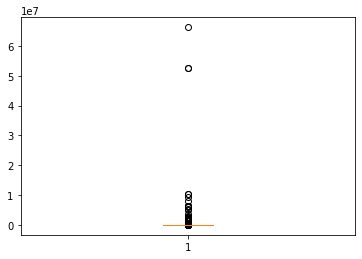

In [25]:
plt.boxplot(ufo_df['duration_seconds'])
plt.show()

There are only 86,400 seconds in one day. If a value is 1M or more, that is more than 11 days. I would think the object would be identified by then since most UFO sightings are brief and untraceable.

In [26]:
ufo_df[ufo_df['duration_seconds'] > 86400]['duration_seconds'].count()

129

In [27]:
ufo_df[(ufo_df['duration_seconds'] > 3600) & (ufo_df['duration_seconds'] <= 86400)]['duration_seconds'].count()

2380

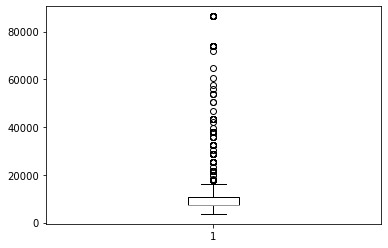

In [28]:
plt.boxplot(ufo_df[(ufo_df['duration_seconds'] > 3600) & (ufo_df['duration_seconds'] <= 86400)]['duration_seconds'])
plt.show()

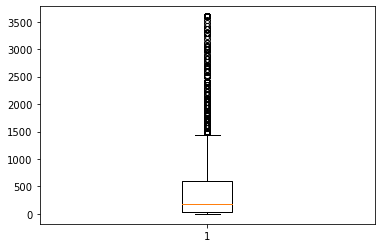

In [29]:
plt.boxplot(ufo_df[ufo_df['duration_seconds'] <= 3600]['duration_seconds'])
plt.show()

In [30]:
duration_median = ufo_df['duration_seconds'].median()
print(duration_median)

180.0


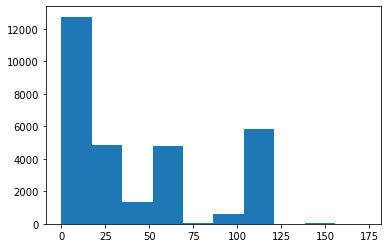

In [31]:
plt.hist(data=ufo_df[ufo_df['duration_seconds'] < duration_median], x='duration_seconds', bins=10)
plt.show()

After some general exploring, I'll simply create some buckets for later.

In [32]:
interval = []
for seconds in ufo_df['duration_seconds']:
    if seconds <= 1:
        interval.append('1s')
    elif seconds <= 2:
        interval.append('2s')
    elif seconds <= 5:
        interval.append('5s')
    elif seconds <= 10:
        interval.append('10s')
    elif seconds <= 15:
        interval.append('15s')
    elif seconds <= 30:
        interval.append('30s')
    elif seconds <= 60:
        interval.append('1m')
    elif seconds <= 120:
        interval.append('2m')
    elif seconds <= 180:
        interval.append('3m')
    elif seconds <= 240:
        interval.append('4m')
    elif seconds <= 300:
        interval.append('5m')
    elif seconds <= 600:
        interval.append('10m')
    elif seconds <= 900:
        interval.append('15m')
    elif seconds <= 1800:
        interval.append('30m')
    elif seconds <= 3600:
        interval.append('hour')
    elif seconds <= 86400:
        interval.append('day')
    elif seconds <= 604800:
        interval.append('week')
    else:
        interval.append('more than a week')

ufo_df.insert(9, 'duration_within', np.nan, True)        
ufo_df['duration_within'] = interval

In [33]:
duration_order = ['1s', '2s', '5s', '10s', '15s', '30s', '1m', '2m', '3m', '4m', '5m', '10m', '15m' ,'30m', 'hour', 'day', 'week', 'more than a week']

Creating a decade to bucket years, if needed.

In [34]:
ufo_df.insert(1, 'decade', np.nan, True)
ufo_df.head()

datetime  decade  year  month  hour  dayofweek        city state  \
0 1949-10-10 20:30:00     NaN  1949     10    20     Monday  San Marcos    TX   
1 1956-10-10 21:00:00     NaN  1956     10    21  Wednesday        Edna    TX   
2 1960-10-10 20:00:00     NaN  1960     10    20     Monday     Kaneohe    HI   
3 1961-10-10 19:00:00     NaN  1961     10    19    Tuesday     Bristol    TN   
4 1965-10-10 23:45:00     NaN  1965     10    23     Sunday     Norwalk    CT   

         shape  duration_seconds duration_within  \
0  Cylindrical            2700.0            hour   
1      Discoid              20.0             30s   
2    Lightform             900.0             15m   
3    Spherical             300.0              5m   
4      Discoid            1200.0             30m   

                                            comments  
0  This event took place in early fall around 194...  
1  My older brother and twin sister were leaving ...  
2  AS a Marine 1st Lt. flying an FJ4B fighter/att...  
3  My father is now 89 my brother 52 the girl wit...  
4  A bright orange color changing to reddish colo...

In [35]:
decade = []
for year in ufo_df['year']:
    year_str = str(year)
    decade.append(year_str[:3] + 'X')
    
ufo_df['decade'] = decade
ufo_df['decade'].head()

0    194X
1    195X
2    196X
3    196X
4    196X
Name: decade, dtype: object

In [36]:
ufo_df.head()

datetime decade  year  month  hour  dayofweek        city state  \
0 1949-10-10 20:30:00   194X  1949     10    20     Monday  San Marcos    TX   
1 1956-10-10 21:00:00   195X  1956     10    21  Wednesday        Edna    TX   
2 1960-10-10 20:00:00   196X  1960     10    20     Monday     Kaneohe    HI   
3 1961-10-10 19:00:00   196X  1961     10    19    Tuesday     Bristol    TN   
4 1965-10-10 23:45:00   196X  1965     10    23     Sunday     Norwalk    CT   

         shape  duration_seconds duration_within  \
0  Cylindrical            2700.0            hour   
1      Discoid              20.0             30s   
2    Lightform             900.0             15m   
3    Spherical             300.0              5m   
4      Discoid            1200.0             30m   

                                            comments  
0  This event took place in early fall around 194...  
1  My older brother and twin sister were leaving ...  
2  AS a Marine 1st Lt. flying an FJ4B fighter/att...  
3  My father is now 89 my brother 52 the girl wit...  
4  A bright orange color changing to reddish colo...

In [37]:
ufo_df.describe()

year         month          hour  duration_seconds
count  65112.000000  65112.000000  65112.000000      6.511200e+04
mean    2004.090106      6.861715     15.655747      5.800307e+03
std       10.385840      3.248218      7.655844      4.045098e+05
min     1910.000000      1.000000      0.000000      1.000000e-02
25%     2001.000000      4.000000     11.000000      3.000000e+01
50%     2007.000000      7.000000     19.000000      1.800000e+02
75%     2011.000000     10.000000     21.000000      6.000000e+02
max     2014.000000     12.000000     23.000000      6.627600e+07

# Exploratory Plotting

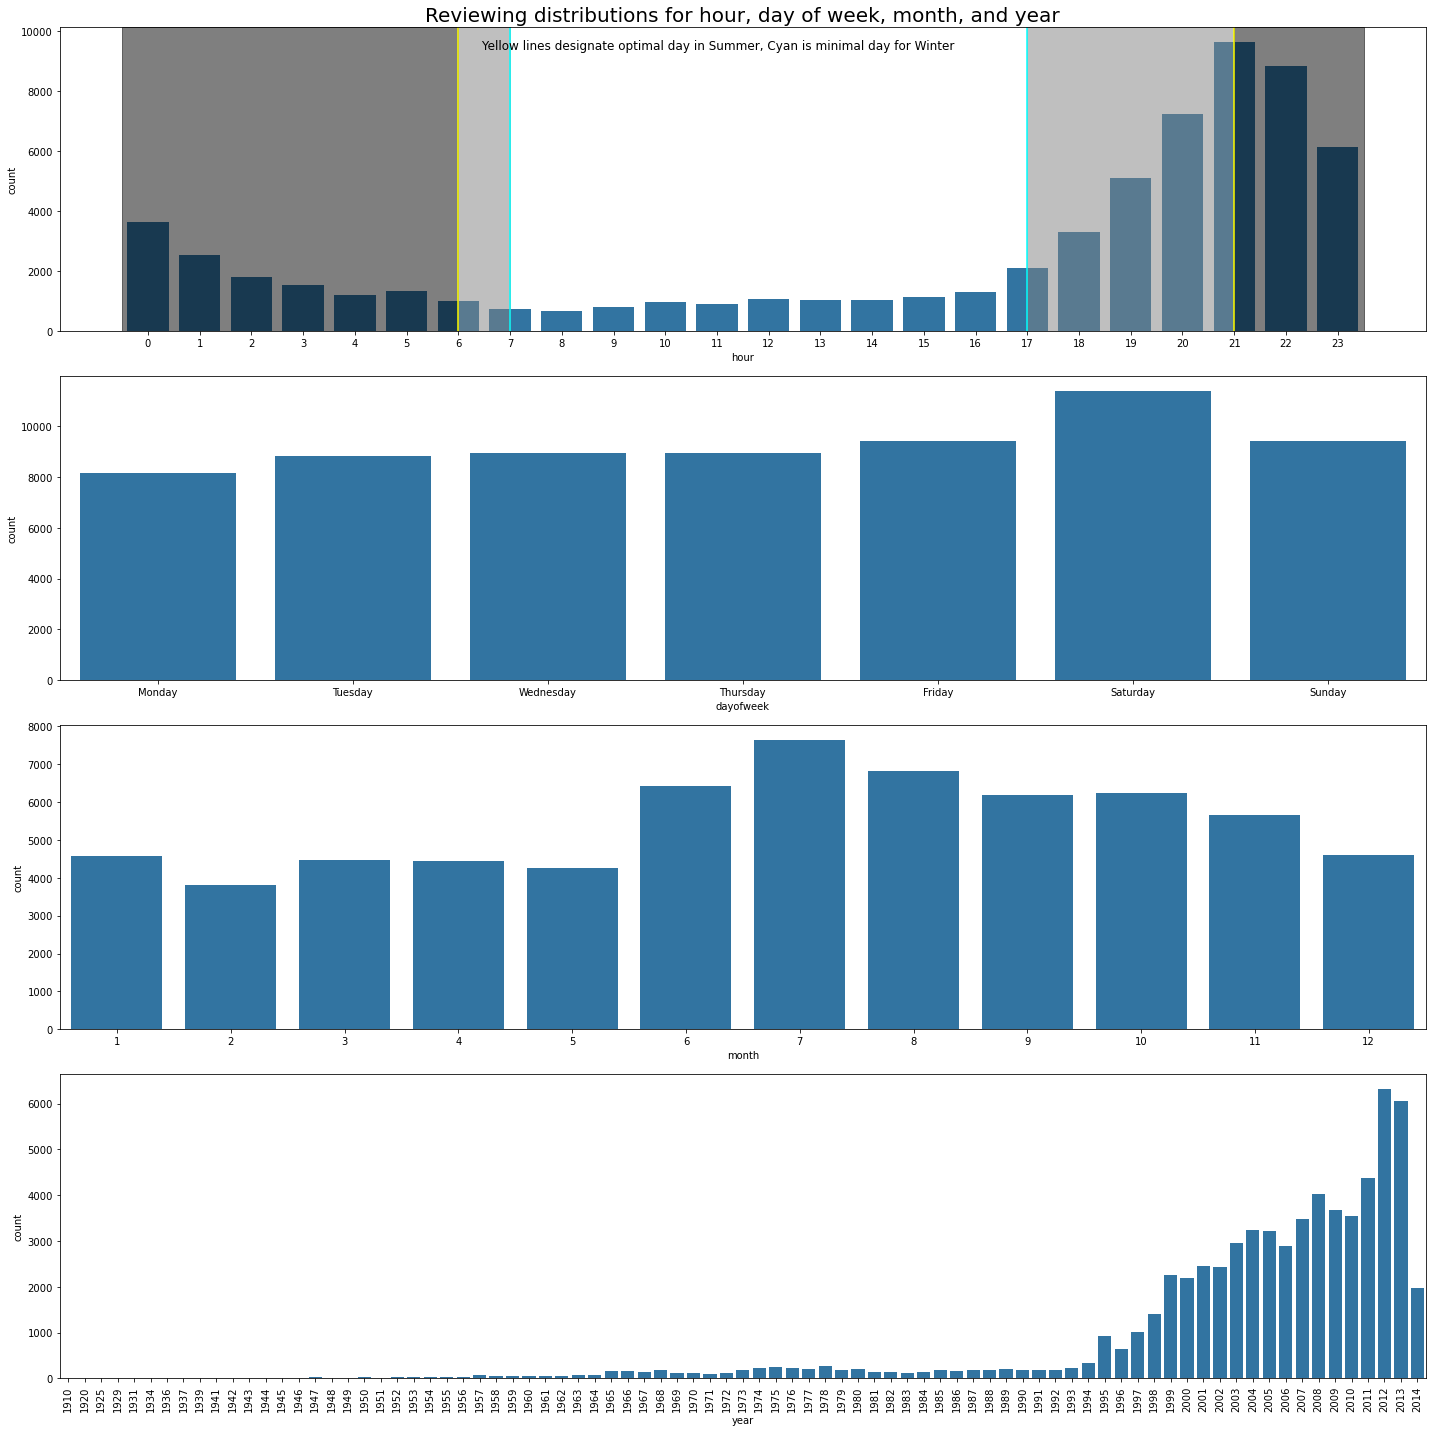

In [38]:
fig, ax = plt.subplots(nrows=4, figsize = [20,20])

default_color = sns.color_palette()[0]
sns.countplot(data = ufo_df, x = 'hour', color = default_color, ax = ax[0])
sns.countplot(data = ufo_df, x = 'dayofweek', order=dayofweek_order, color = default_color, ax = ax[1])
sns.countplot(data = ufo_df, x = 'month', color = default_color, ax = ax[2])
sns.countplot(data = ufo_df, x = 'year', color = default_color, ax = ax[3])
ax[0].axvline(x=6, c='yellow')
ax[0].axvline(x=7, c='cyan')
ax[0].axvline(x=17, c='cyan')
ax[0].axvline(x=21, c='yellow')
ax[0].axvspan(-0.5, 6, alpha=0.5, color='black')
ax[0].axvspan(6, 7, alpha=0.5, color='grey')
ax[0].axvspan(17, 21, alpha=0.5, color='grey')
ax[0].axvspan(21, 23.5, alpha=0.5, color='black')
ax[0].set_title('Reviewing distributions for hour, day of week, month, and year', fontsize=20)
plt.xticks(rotation=90)
plt.suptitle('\n Yellow lines designate optimal day in Summer, Cyan is minimal day for Winter')
plt.tight_layout()
plt.show()

Common times of sightings are 9-10PM or in the month of July, which is somewhat curious. Winter months are darker longer and you might expect to find higher occurances during that time. Since, in the US, it becomes night around 9PM in the summer months, is there something to do with sunsets that create "UFOs?" January through May seem about the same on the number of sightings, but it is odd to see a jump into June with a tapering off the rest of the year. In terms of day of the week, the number of sightings increase as the week progresses, then jumps by Saturday and drops off by Sunday. Is it surprising? Or is it as more people are on their free time, the higher likelihood they will spot something?

*The X-files* aired September 10, 1993 until May 19, 2002 with a return of only 6 episodes in 2016 and 10 episodes in 2018. Could the huge upswing in the late 90s be because of the show? Only speculation at this point.

Let's take a look at hours, days of the week, and months more closely.

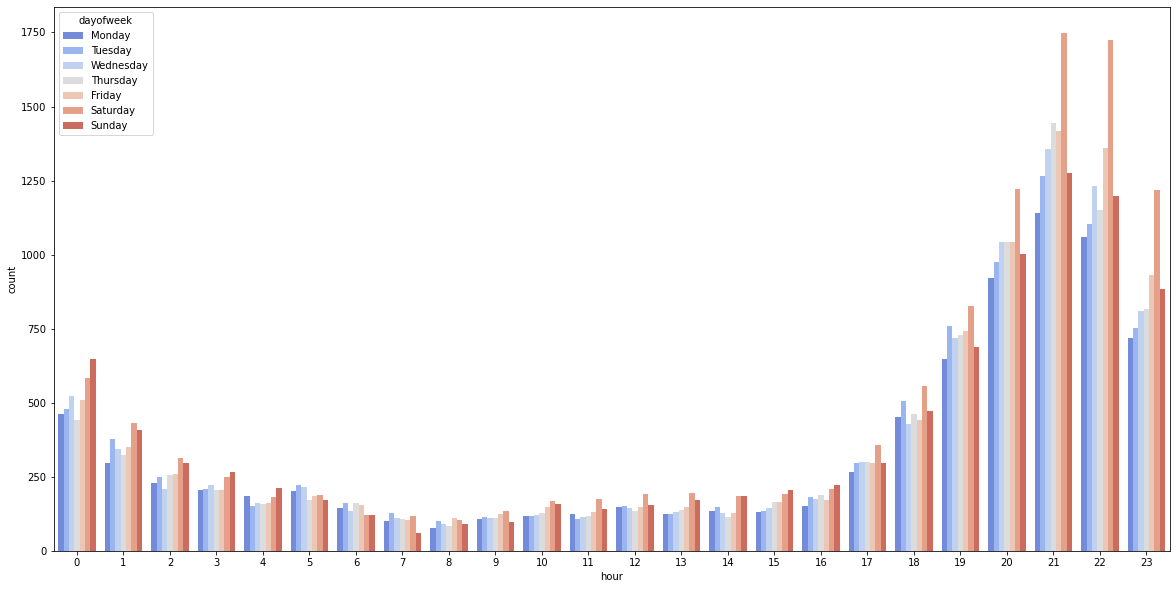

In [39]:
fig, ax = plt.subplots(nrows=1, figsize = [20,10])
sns.countplot(data = ufo_df, x = 'hour', hue='dayofweek', hue_order=dayofweek_order, palette="coolwarm")
plt.show()

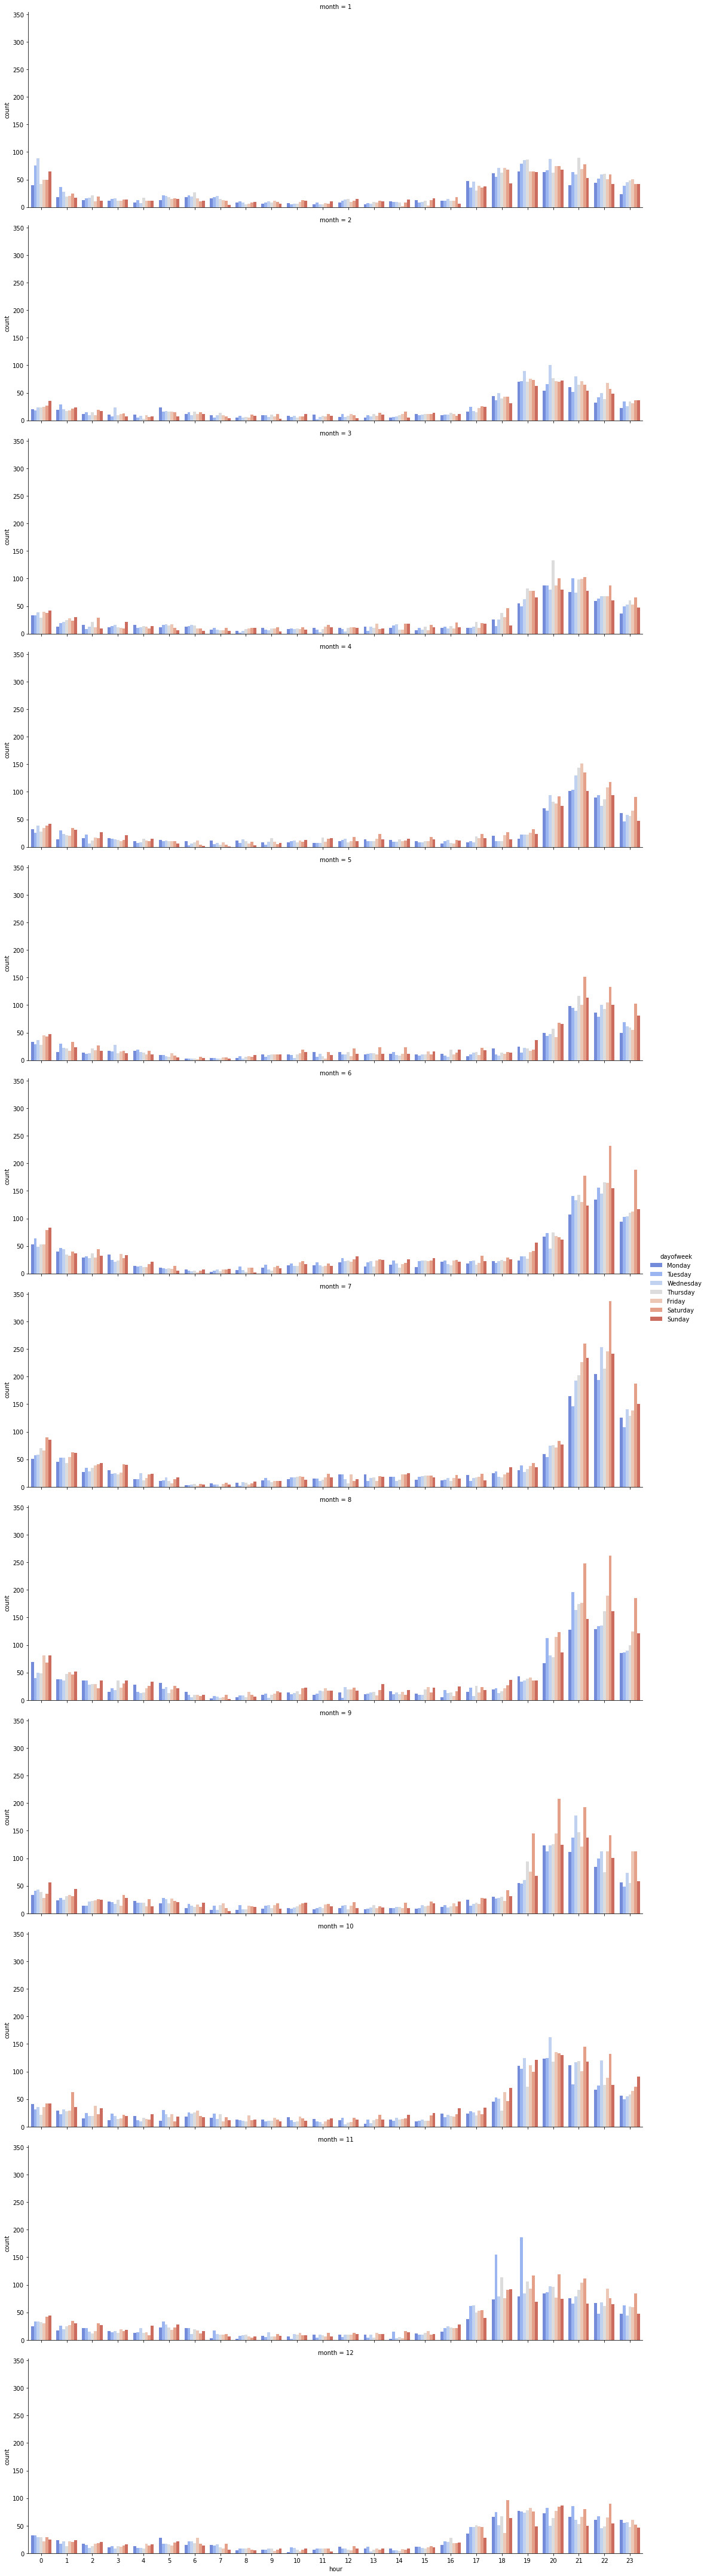

In [40]:
sns.catplot(data = ufo_df, x = 'hour', row='month', hue='dayofweek', hue_order=dayofweek_order, palette="coolwarm", kind="count", height=5, aspect=3)
plt.show()

You can definitely see a weekend pattern, especially sightings coming from Saturday night into Sunday morning.

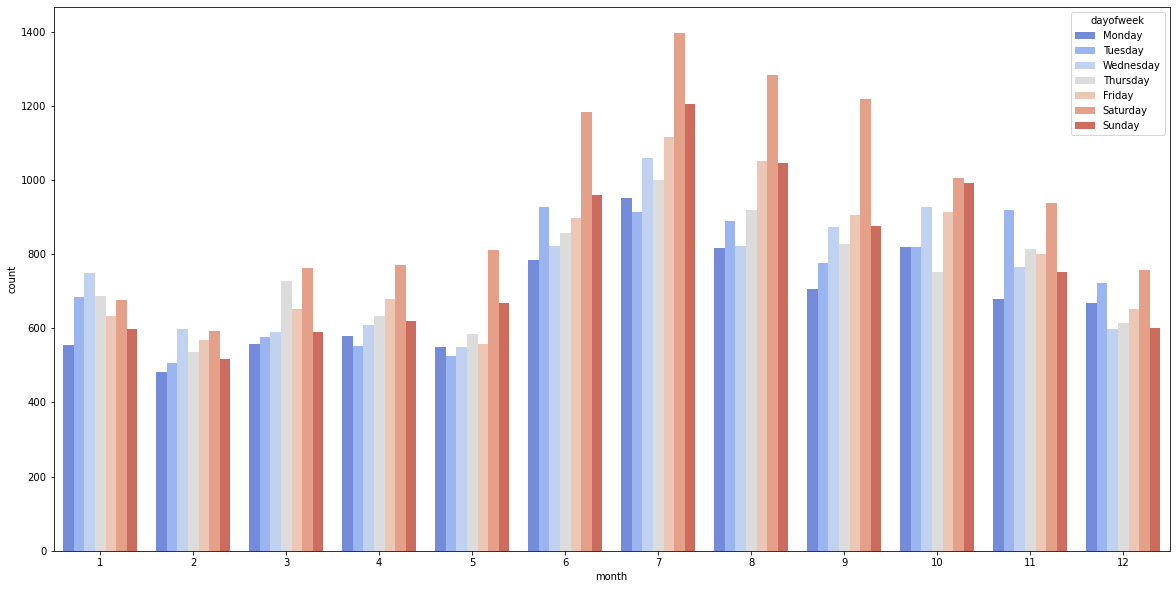

In [41]:
fig, ax = plt.subplots(nrows=1, figsize = [20,10])
sns.countplot(data = ufo_df, x = 'month', hue='dayofweek', hue_order=dayofweek_order, palette="coolwarm")
plt.show()

Saturday seems to dominate starting in March through December with Sunday being a close second in October. It's curious that earlier in the week shows importance in the winter months.

In [42]:
sightings = []

for year in sorted(list(set(ufo_df['year']))):
    sightings.append([year, ufo_df[ufo_df['year']==year]['year'].count()])
    
ufo_sightings = pd.DataFrame(sightings, columns=["year","count"])
ufo_sightings.head()

year  count
0  1910      2
1  1920      1
2  1925      1
3  1929      1
4  1931      2

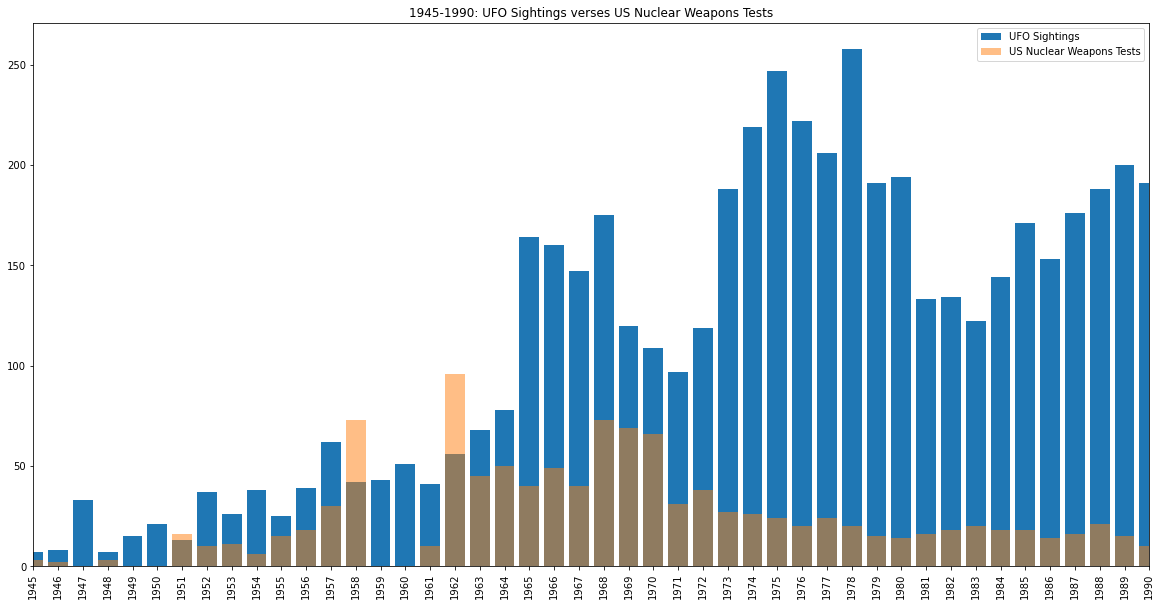

In [43]:
fig, ax = plt.subplots(figsize = [20,10], sharex=True, sharey=True)
plt.bar('year', 'count', data = ufo_sightings[ufo_sightings['year'] <= 1990] , label='UFO Sightings')
plt.bar('Year','detonation_count', data = us_nuke_df[us_nuke_df['Year'] <= 1990], label='US Nuclear Weapons Tests', alpha = 1/2)
plt.xlim(1945,1990)
plt.xticks(list(range(1945,1991)), rotation=90)
plt.title('1945-1990: UFO Sightings verses US Nuclear Weapons Tests')
ax.legend()
plt.show()

The famous incident in Roswell, New Mexico was in 1947, which may explain the surge in sightings. 1957 was the launch of the *Sputnik*. It could be the case with technological testing and advancement in the military that sightings increased, especially in the 1960s. 

Jet propulsion was put into use by the Germans during the latter part of World War II, but jet propulsion was being developed through Europe before then. The US did develop a working concept also during the war, but did not have working models in the war like the Germans. Operation Paperclip, a US secret operation to recruit German scientists after the war propelled US aerospace programs through the 50s and 60s. 

Further historical research in technological advancements may reveal why the surges happened when they did - space flights from the US and USSR might be of interest; civil and (if possible) military air travel would be interesting as well. For example, Pan-Am put to service jet aircraft in 1958 with the Boeing 707, a model used into the 70s.

In [44]:
ufo_df['datetime'].max()

Timestamp('2014-05-08 00:00:00')

2014 is an incomplete year. Noted for later.

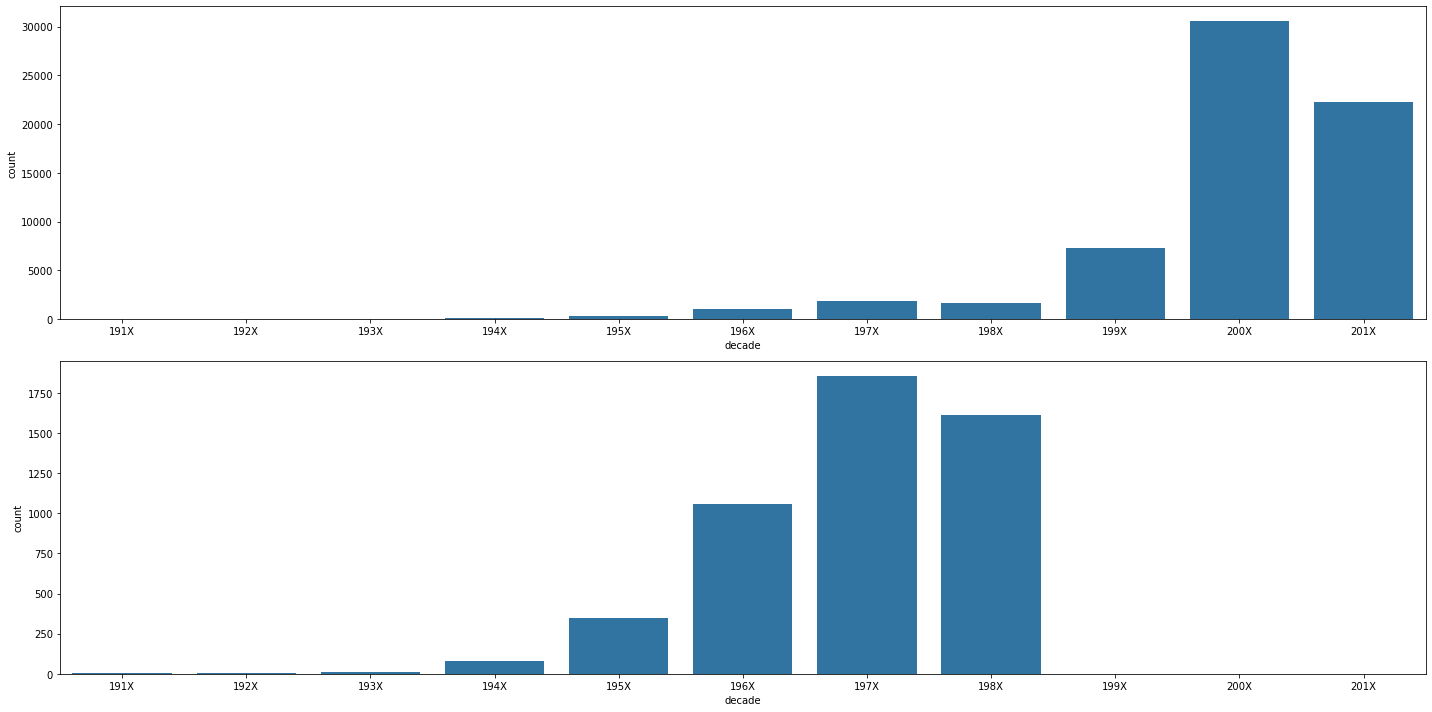

In [45]:
decade_list = sorted(list(set(ufo_df['decade'])))

fig, ax = plt.subplots(nrows=2, figsize = [20,10])
sns.countplot(data=ufo_df, x='decade', color = default_color, order = decade_list, ax = ax[0])
sns.countplot(data=ufo_df[ufo_df['year']<=1989], x='decade', color = default_color, order = decade_list, ax = ax[1])
plt.tight_layout()
plt.show()

By decade, we see the surge from the 40s into the 70s, but a drop off in the 80s before a sharp increase from the 90s. The Cold War waned in the 80s, but the space race cooled after the US stopped making trips to the moon with the Apollo missions. General speculations here, but it could be accounted for by the swell of development of technology and transportation. It might be the case, too, that the beginning of the internet in common households of the 90s may magnify people's exposure to information and inspiration to possibly find UFOs.

Let's take a look at number of sightings by state and city.

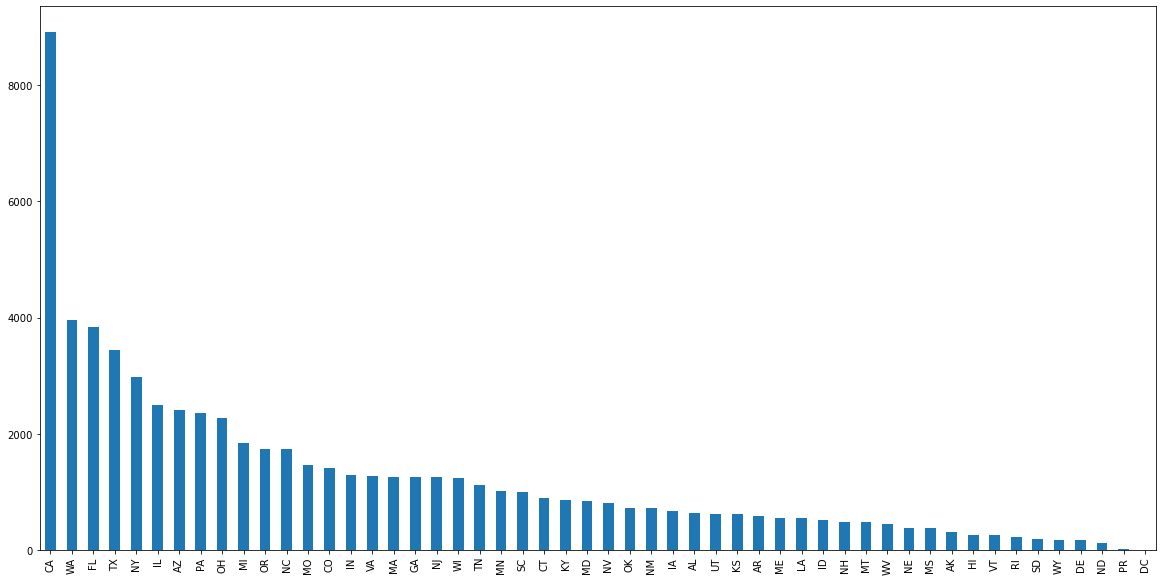

In [46]:
plt.figure(figsize=[20, 10])
ufo_df['state'].value_counts().plot(kind='bar')
plt.show()

In [47]:
city_df = ufo_df['city'].value_counts().rename_axis('city').reset_index(name='counts')
city_df.head(10)

city  counts
0      Seattle     524
1      Phoenix     454
2     Portland     373
3    Las Vegas     367
4  Los Angeles     352
5    San Diego     338
6      Houston     297
7      Chicago     264
8       Tucson     241
9        Miami     239

In [48]:
city_df['counts'].describe()

count    11364.000000
mean         5.729673
std         16.758640
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        524.000000
Name: counts, dtype: float64

California has the most sightings followed by Virginia, Florida, Texas, New York, Illinois, Arizona, Pennsylvania, Ohio, and Michigan. The top 10 cities for sightings are major cities.

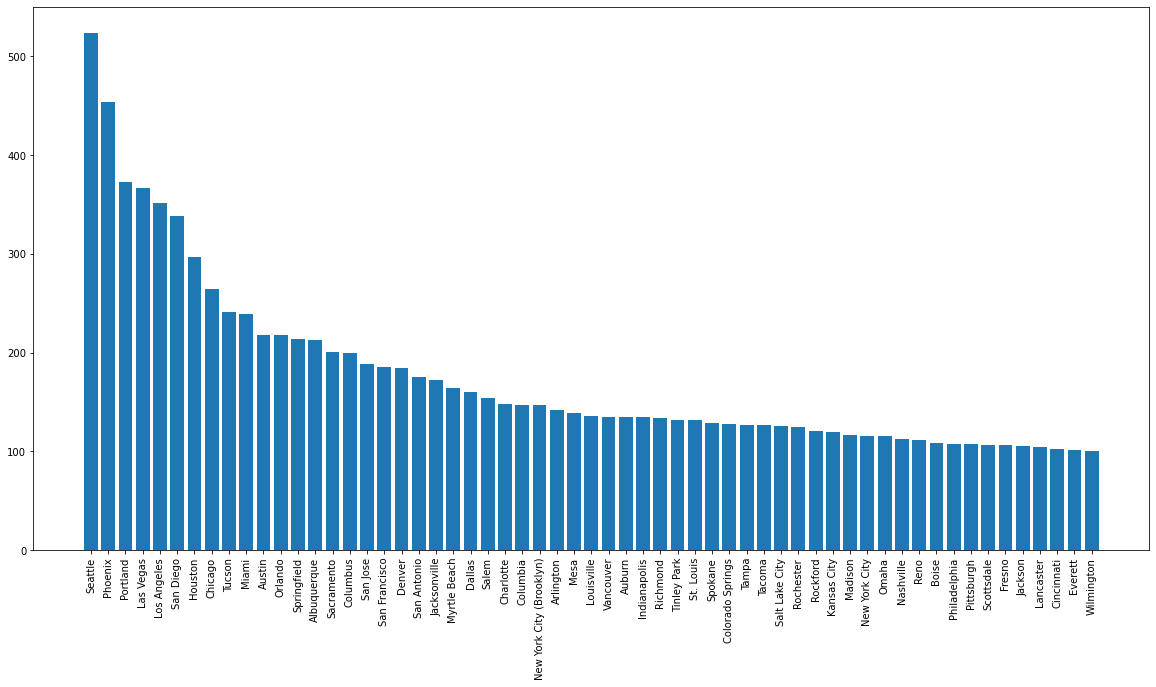

In [49]:
plt.figure(figsize=[20, 10])
plt.bar('city', 'counts', data=city_df[city_df['counts'] > 100])
plt.xticks(rotation=90)
plt.show()

Being around major cities can muddy sightings due to frequent air travel or mistaken light pollution.

In [50]:
ufo_df['city'].nunique()

11364

Seeing "New York City (Brooklyn)" in the bar chart makes me wonder what other ways cities are handled or if there may be typos or extra characters in the names. With 11,364 unique names, it will be difficult to make sure all names are accurate. It would be nice to classify cities by size, even though that would be by present-day standards. The aim would be to look at the number or average number of sightings there are within city sizes to see if sizes relates to higher number of sightings. If that's true, at least two things can be said: population size detemines how often a UFO is sighted or the frequency of air travel (or higher chance of an airport in a larger city) and the level of light pollution can potentially increase the numberof UFO sightings.

If there are anomalies of smaller populated cities with relatively high sightings, then we could look at these and determine what might cause this. If not much can be said about being near airports or military bases, then perhaps something might be revealing about possible UFO sightings.

Let's continue to look through the data to see if we can find something that might lead to more plausible sightings.

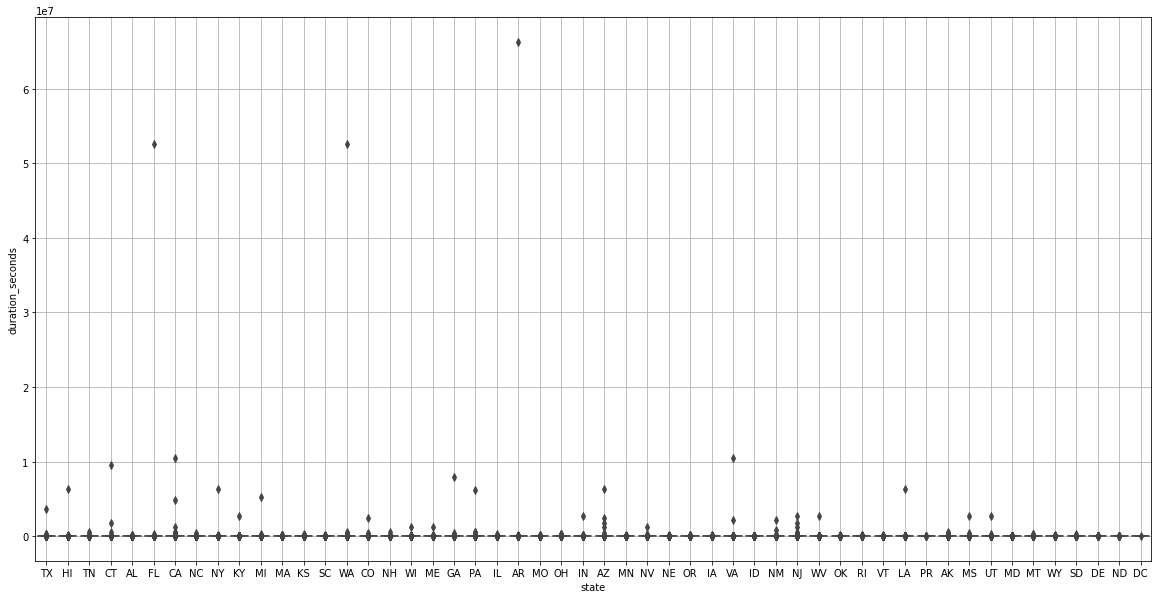

In [51]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_df, x = 'state', y = 'duration_seconds')
plt.grid(True)
plt.show()

Even though, this graph is not very useful, it does show states with unusually long durations: California, Washington, and Arkansas. The states with durations within 1M seconds are Texas, Hawaii, Connecticut, New York, Kentucky, Michigan, Colorado, Wisconisn, Maine, Georgia, Pennsylvannia, Indiana, Arizona, Nevada, Virginia, New Mexico, New Jersey, West Virginia, Louisianna, Mississippi, and Utah. Let's instead look at these with duration up to one day, or 24hrs.

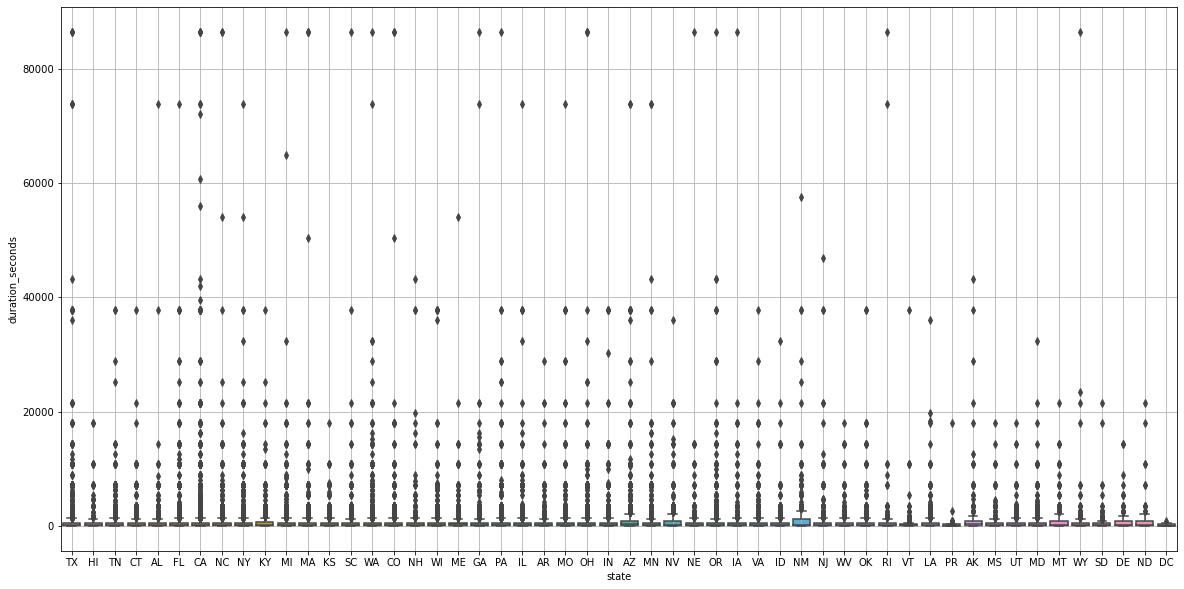

In [52]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_df[ufo_df['duration_seconds'] <= 86400], x = 'state', y = 'duration_seconds')
plt.grid(True)
plt.show()

What about within 1 hour?

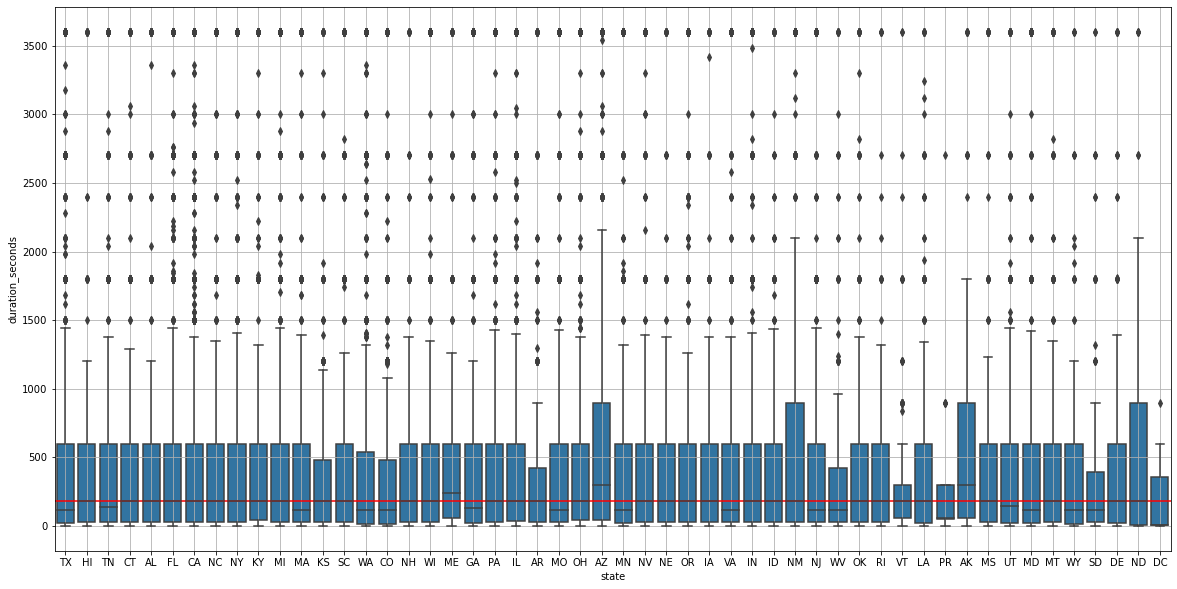

In [53]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_df[ufo_df['duration_seconds'] <= 3600], x = 'state', y = 'duration_seconds', color = default_color)
plt.axhline(duration_median, c='red')
plt.grid(True)
plt.show()

Arizona, New Mexico, Alaska, and North Dakota show a much wider spread than any other states. In contrast, Vermont and Puerto Rico have the smallest spread, preceded by Kansas, Colorado, Arkansas, West Virginia, South Dakota, and D.C. 

Without a rigorous search and looking with a glance, these two sources show military activity within the United States present day: 
- https://www.thebalancecareers.com/us-military-major-bases-4061575
    - 15 States listed: Alaska, Alabama, California (most bases in the U.S.), Colorado, Florida, Georgia, Kentucky, Michigan, Missouri, New York, Ohio, Pennsylvania, Texas, Tennessee, and Virginia
- https://www.thebalanceeveryday.com/united-states-air-force-major-bases-and-installations-3344134
    - 36 States listed: Alabama, Alaska, Arizona, Arkansas, California, Colorado, Delaware, D.C., Florida, Georgia, Hawaii, Idaho, Illinois, Kansas, Louisiana, Maryland, Massachusetts, Mississippi, Missouri, Montana, Nebraska, Nevada, New Jersey, New Mexico, North Carolina, North Dakota, Ohio, Oklahoma, South Carolina, South Dakota, Tennessee, Texas, Utah, Virginia, Washington, and Wyomming.
    
From this, in total with Kentucky, Michigan, New York, and Pennsylvania not mentioned in the second list, comes to 39 states (plus D.C.) with military installations. 


Working within a 1-hour period only, let's see what we can find from this piece-mealed information.

In [54]:
ufo_1hr_df = ufo_df[(ufo_df['state'] != 'PR') & (ufo_df['duration_seconds'] <= 3600) & (ufo_df['year'] < 2014)]
ufo_1hr_df.reset_index(drop=True, inplace=True)

In [55]:
has_military = []
for state in ufo_1hr_df['state']:
    if state in ['CT','IN','IA','ME','MN','NH','OR','RI','VT','WV','WI']:
        has_military.append('N')
    else:
        has_military.append('Y')
        
ufo_1hr_df.insert(8, 'military_presence', np.nan, True)
ufo_1hr_df['military_presence'] = has_military

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [56]:
sorted(list(set(ufo_1hr_df[ufo_1hr_df['military_presence']=='N']['state'])))

['CT', 'IA', 'IN', 'ME', 'MN', 'NH', 'OR', 'RI', 'VT', 'WI', 'WV']

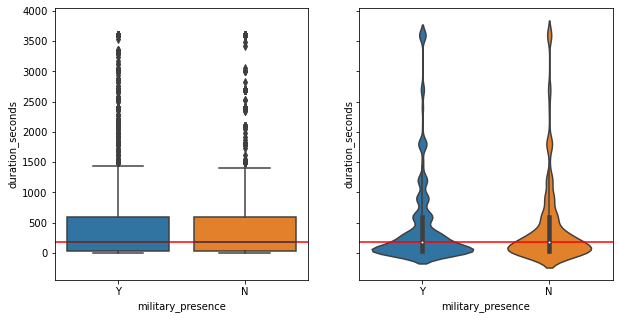

In [57]:
fig, ax = plt.subplots(ncols=2, figsize = [10,5], sharey=True)
sns.boxplot(data = ufo_1hr_df, x = 'military_presence', y = 'duration_seconds', ax=ax[0])
sns.violinplot(data = ufo_1hr_df, x = 'military_presence', y = 'duration_seconds', ax=ax[1])
ax[0].axhline(duration_median, c='red')
ax[1].axhline(duration_median, c='red')
plt.show()

In [58]:
print('Median of states with military presence: ', ufo_1hr_df[ufo_1hr_df['military_presence']=='Y']['duration_seconds'].median())
print('Median of states without military presence: ', ufo_1hr_df[ufo_1hr_df['military_presence']=='N']['duration_seconds'].median())

Median of states with military presence:  180.0
Median of states without military presence:  180.0


In [59]:
print('Mean of states with military presence: ', ufo_1hr_df[ufo_1hr_df['military_presence']=='Y']['duration_seconds'].mean())
print('Mean of states without military presence: ', ufo_1hr_df[ufo_1hr_df['military_presence']=='N']['duration_seconds'].mean())

Mean of states with military presence:  480.2723388671875
Mean of states without military presence:  456.7523498535156


Not a lot to be said here, except the mean is skewed more with military presence than without. Of course, this information is not comprehensive or exact, especially as bases were constructed and abandoned over time. With more in-depth data, this might be very revealing or interesting.

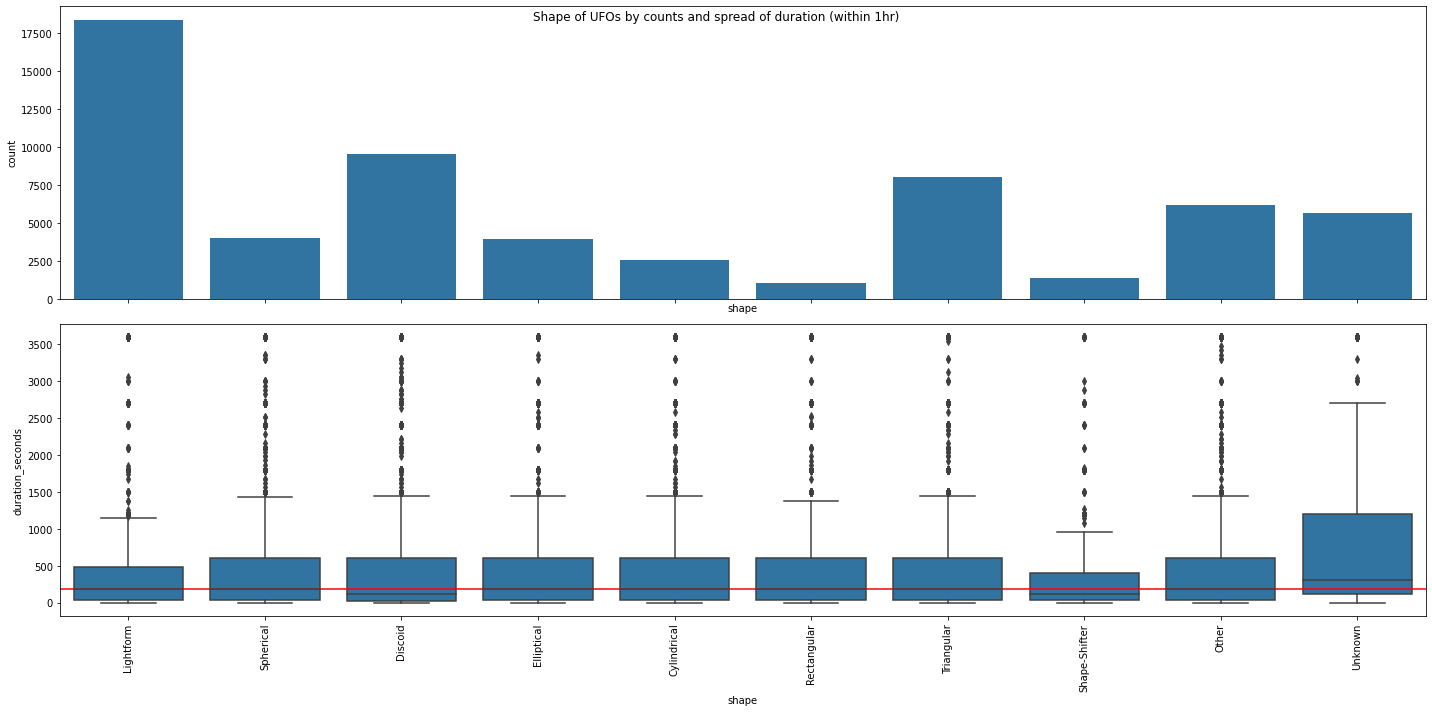

In [60]:
shape_order = ['Lightform','Spherical','Discoid','Elliptical','Cylindrical','Rectangular','Triangular','Shape-Shifter','Other','Unknown']
shape_index = list(range(0,len(shape_order)))

fig, ax = plt.subplots(nrows=2, figsize = [20,10], sharex = True)
sns.countplot(data=ufo_1hr_df, x = 'shape', color = default_color, order = shape_order, ax = ax[0])
sns.boxplot(data = ufo_1hr_df, x = 'shape', y = 'duration_seconds', color = default_color, ax = ax[1])
ax[1].axhline(duration_median, c='red')
plt.xticks(shape_index, shape_order, rotation=90)
plt.suptitle('Shape of UFOs by counts and spread of duration (within 1hr)')
plt.tight_layout()
plt.show()

Couple of interesting things to note: Lightforms are most common and have the second shortest spread in duration (fast aircraft at night?), while Unknown has the largest spread (can't describe it, could be anything). Discoid and shapeshifter have the lowest medians.

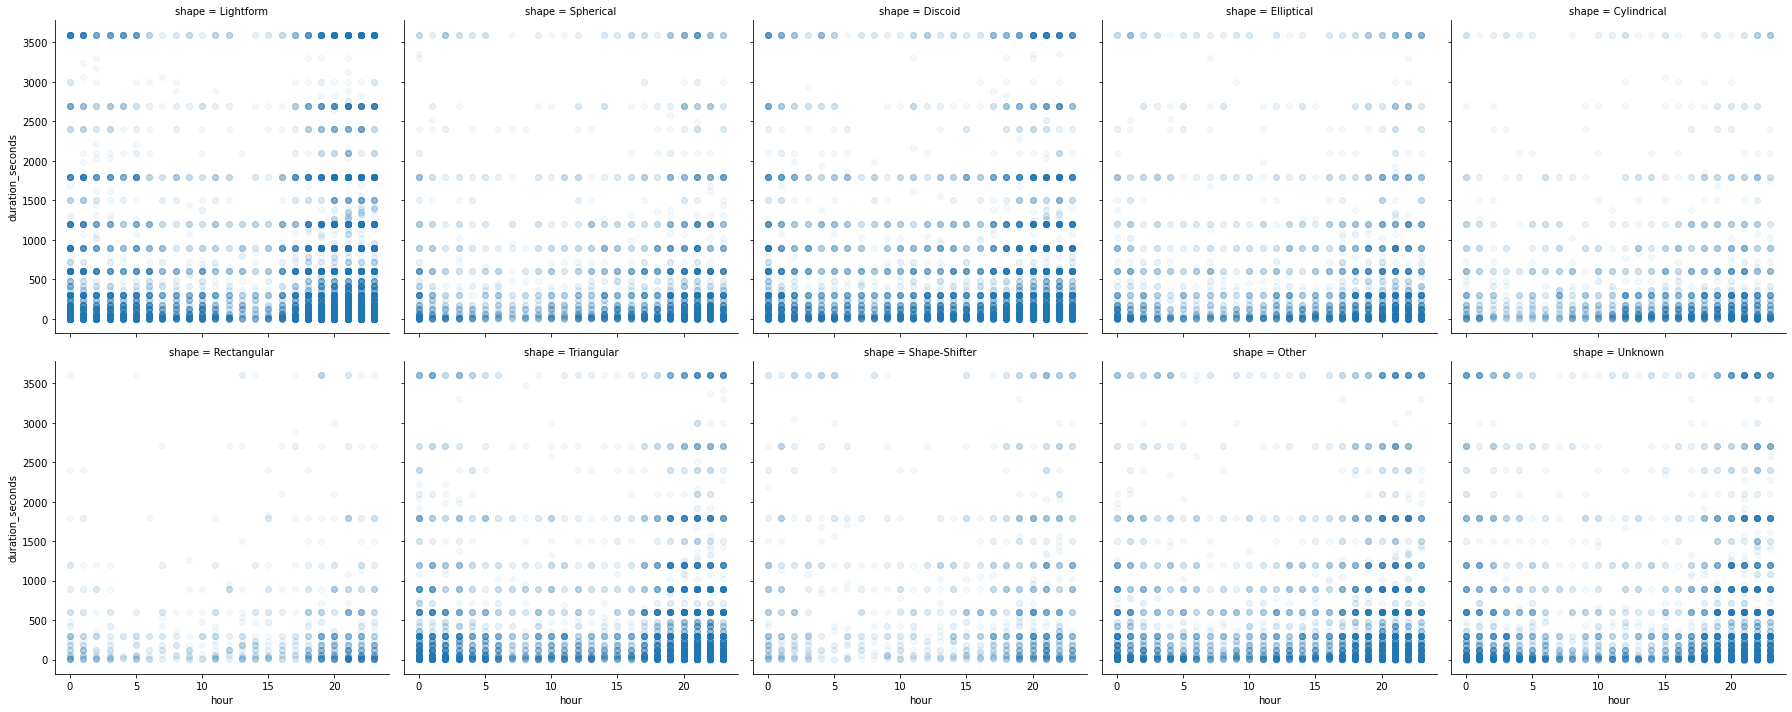

In [61]:
g = sns.FacetGrid(data = ufo_1hr_df, col = 'shape', col_order = shape_order, col_wrap = 5, height = 5)
g.map(plt.scatter, 'hour','duration_seconds', alpha = 1/20)
plt.show()

If anything can be said here it's that night-time activity is present in all of these shapes from dusk until midnight. Tapering in most of these shapes happens after midnight and almost disappearing around noon. Spherical and Elliptical have similar phenomenon where a gradual increase happens from early morning til around 10PM or so before declining. Discoid seems almost always present, while Cylindrical has a more constant presence after noon.

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


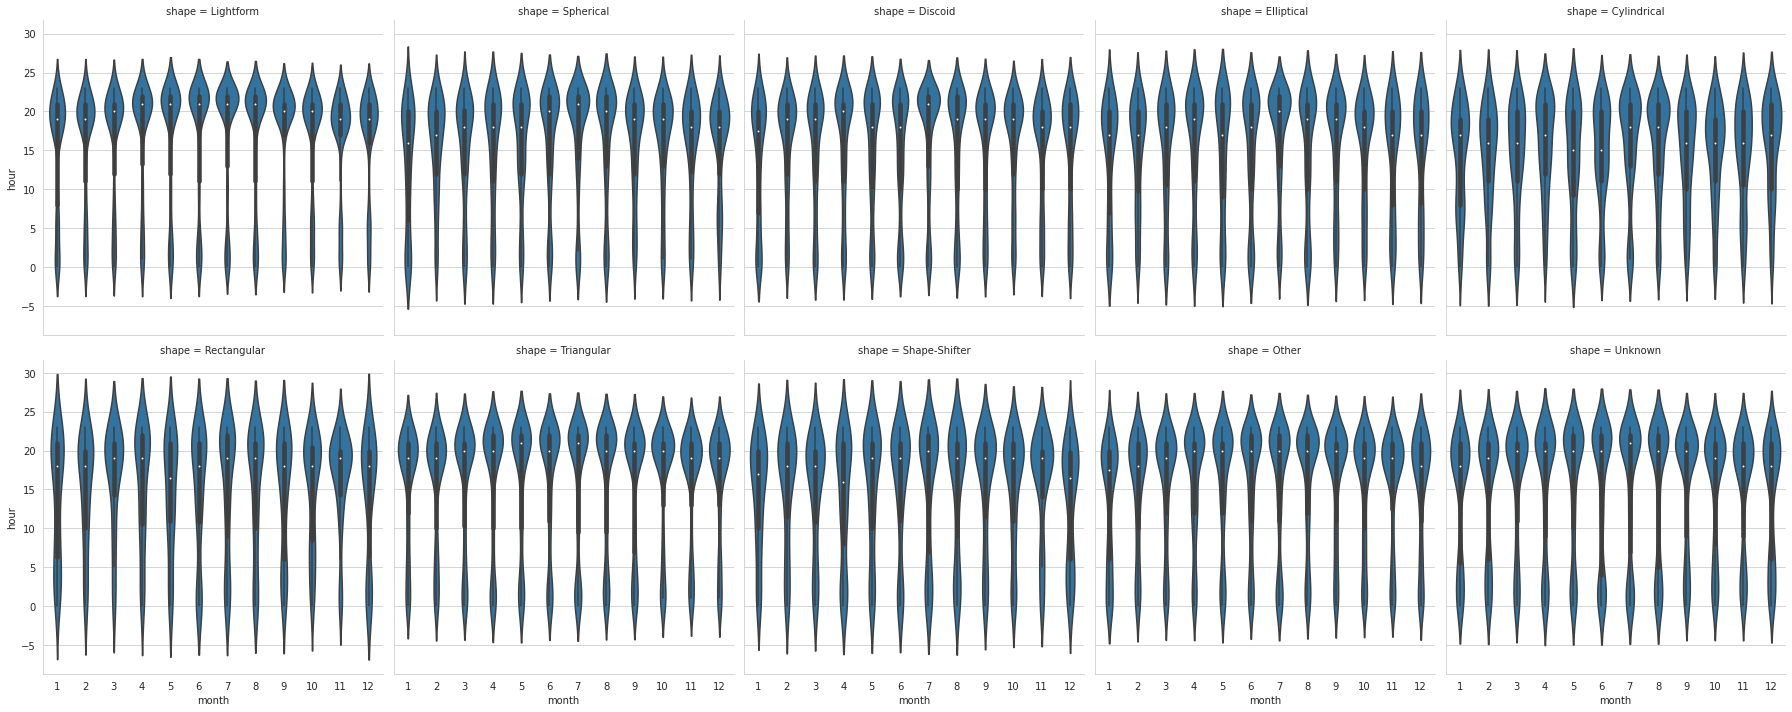

In [62]:
sns.set_style("whitegrid")
g = sns.FacetGrid(data = ufo_1hr_df, col = 'shape', col_order = shape_order, col_wrap = 5, height = 5)
g.map(sns.violinplot, 'month','hour')
plt.show()

In [63]:
sns.set_style("white")

Time of year doesn't seem to show much new information, but confirms some previous observations. Notice how lightform stick to the night between 7 and midnight as length of the day changes through the year. Triangular is closely behind that, but with more early morning activity. Most of the rest have an emphasis in January for some reason, while cylindrical, shapeshifter and rectangular have more daytime activity in addtion to nighttime.

Let's take a look at these shapes over the years. Do we have any that have a special pattern developing?

In [64]:
lightform = []
spherical = []
discoid = []
elliptical = []
cylindrical = []
rectangular = []
triangular = []
shape_shifter = []
other = []
unknown = []

for shape in shape_order:
    if shape == shape_order[0]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            lightform.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[1]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            spherical.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[2]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            discoid.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[3]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            elliptical.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[4]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            cylindrical.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[5]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            rectangular.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[6]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            triangular.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[7]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            shape_shifter.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[8]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            other.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    if shape == shape_order[9]:
        for year in sorted(list(set(ufo_1hr_df['year']))):
            unknown.append([year, ufo_1hr_df[(ufo_1hr_df['year']==year) & (ufo_df['shape']==shape)]['shape'].count()])
    
lightform_df = pd.DataFrame(lightform, columns=["year","count"])
spherical_df = pd.DataFrame(spherical, columns=["year","count"])
discoid_df = pd.DataFrame(discoid, columns=["year","count"])
elliptical_df = pd.DataFrame(elliptical, columns=["year","count"])
cylindrical_df = pd.DataFrame(cylindrical, columns=["year","count"])
rectangular_df = pd.DataFrame(rectangular, columns=["year","count"])
triangular_df = pd.DataFrame(triangular, columns=["year","count"])
shape_shifter_df = pd.DataFrame(shape_shifter, columns=["year","count"])
other_df = pd.DataFrame(other, columns=["year","count"])
unknown_df = pd.DataFrame(unknown, columns=["year","count"])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexe

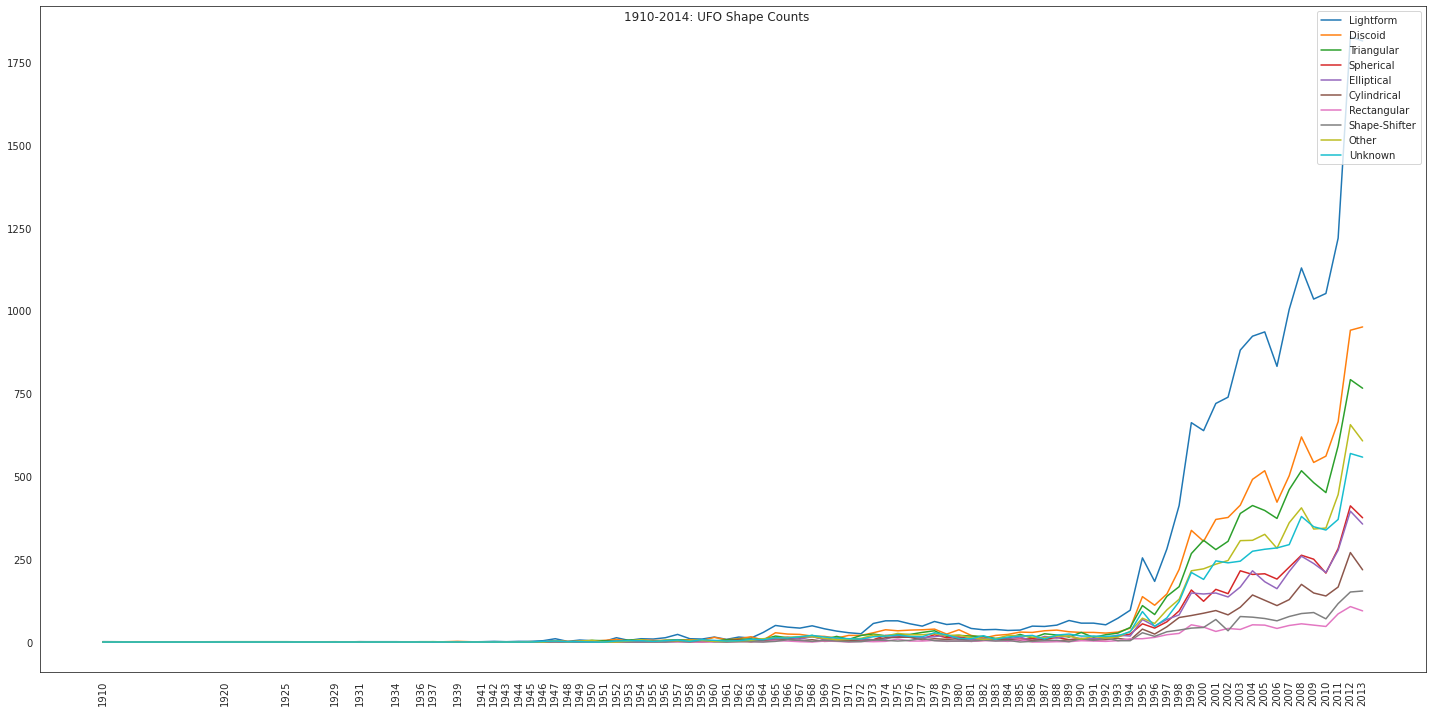

In [65]:
fig, ax = plt.subplots(nrows=1, figsize = [20,10], sharex=True, sharey=True)
ax.plot('year', 'count', data = lightform_df, label='Lightform')
ax.plot('year', 'count', data = discoid_df, label='Discoid')
ax.plot('year', 'count', data = triangular_df, label='Triangular')
ax.plot('year', 'count', data = spherical_df, label='Spherical')
ax.plot('year', 'count', data = elliptical_df, label='Elliptical')
ax.plot('year', 'count', data = cylindrical_df, label='Cylindrical')
ax.plot('year', 'count', data = rectangular_df, label='Rectangular')
ax.plot('year', 'count', data = shape_shifter_df, label='Shape-Shifter')
ax.plot('year', 'count', data = other_df, label='Other')
ax.plot('year', 'count', data = unknown_df, label='Unknown')
plt.xticks(sorted(list(set(ufo_1hr_df['year']))), rotation=90)
plt.suptitle('1910-2014: UFO Shape Counts')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

Nothing special so far. Now let's break these into two time frames, 1910-1989 and 1990-2014.

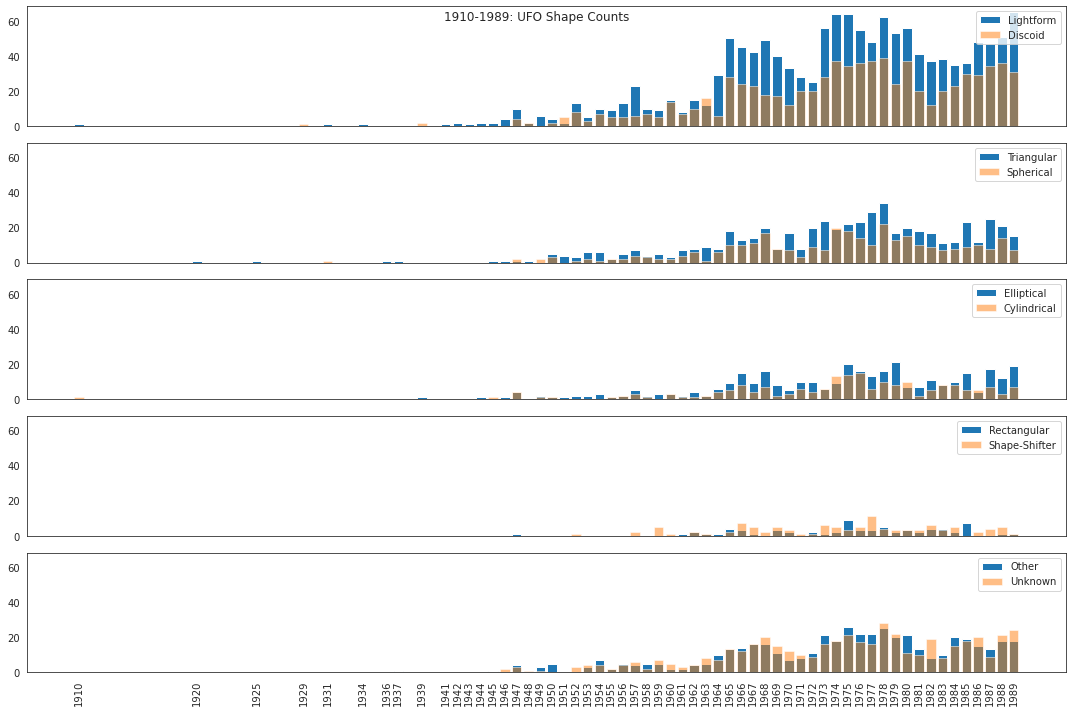

In [66]:
fig, ax = plt.subplots(nrows=5, figsize = [15,10], sharex=True, sharey=True)
ax[0].bar('year', 'count', data = lightform_df[lightform_df['year']<=1989], label='Lightform')
ax[0].bar('year', 'count', data = discoid_df[discoid_df['year']<=1989], label='Discoid', alpha = 1/2)
ax[1].bar('year', 'count', data = triangular_df[triangular_df['year']<=1989], label='Triangular')
ax[1].bar('year', 'count', data = spherical_df[spherical_df['year']<=1989], label='Spherical', alpha = 1/2)
ax[2].bar('year', 'count', data = elliptical_df[elliptical_df['year']<=1989], label='Elliptical')
ax[2].bar('year', 'count', data = cylindrical_df[cylindrical_df['year']<=1989], label='Cylindrical', alpha = 1/2)
ax[3].bar('year', 'count', data = rectangular_df[rectangular_df['year']<=1989], label='Rectangular')
ax[3].bar('year', 'count', data = shape_shifter_df[shape_shifter_df['year']<=1989], label='Shape-Shifter', alpha = 1/2)
ax[4].bar('year', 'count', data = other_df[other_df['year']<=1989], label='Other')
ax[4].bar('year', 'count', data = unknown_df[unknown_df['year']<=1989], label='Unknown', alpha = 1/2)
plt.xticks(sorted(list(set(ufo_1hr_df[ufo_1hr_df['year']<=1989]['year']))), rotation=90)
plt.suptitle('1910-1989: UFO Shape Counts')
ax[0].legend(loc='upper right')
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
plt.tight_layout()
plt.show()

1910 is definitely something to wonder about, especially anything before common commercial flight of the 50s - trains were king before that. This could be weather balloon or airship sightings. Lightform and Discoid come into view in the 40s with Triangular and Spherical to follow. Elliptical and Cylindrical seem to have a late start into the 60s, and Rectangular and Shape-Shifter have a mixed timeline also starting in the 60s. Other and Unknown seem to roughly move about the same. Of course, we're assuming our new categories are appropriate to some degree. We are relying on the initial shape label to being correctly recorded from the sighting. Drawing conclusions are approximate speculations.

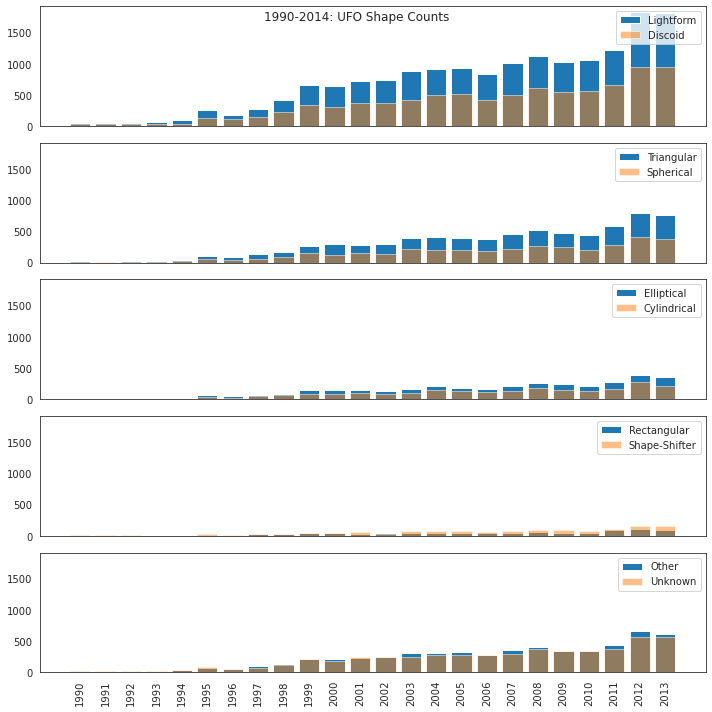

In [67]:
fig, ax = plt.subplots(nrows=5, figsize = [10,10], sharex=True, sharey=True)
ax[0].bar('year', 'count', data = lightform_df[lightform_df['year']>1989], label='Lightform')
ax[0].bar('year', 'count', data = discoid_df[discoid_df['year']>1989], label='Discoid', alpha = 1/2)
ax[1].bar('year', 'count', data = triangular_df[triangular_df['year']>1989], label='Triangular')
ax[1].bar('year', 'count', data = spherical_df[spherical_df['year']>1989], label='Spherical', alpha = 1/2)
ax[2].bar('year', 'count', data = elliptical_df[elliptical_df['year']>1989], label='Elliptical')
ax[2].bar('year', 'count', data = cylindrical_df[cylindrical_df['year']>1989], label='Cylindrical', alpha = 1/2)
ax[3].bar('year', 'count', data = rectangular_df[rectangular_df['year']>1989], label='Rectangular')
ax[3].bar('year', 'count', data = shape_shifter_df[shape_shifter_df['year']>1989], label='Shape-Shifter', alpha = 1/2)
ax[4].bar('year', 'count', data = other_df[other_df['year']>1989], label='Other')
ax[4].bar('year', 'count', data = unknown_df[unknown_df['year']>1989], label='Unknown', alpha = 1/2)
plt.xticks(sorted(list(set(ufo_1hr_df[ufo_1hr_df['year']>1989]['year']))), rotation=90)
plt.suptitle('1990-2014: UFO Shape Counts')
ax[0].legend(loc='upper right')
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
plt.tight_layout()
plt.show()

Seems like there is not much to be said as it seems most of these follow along with each other, just on different magnitudes, which makes you question what we might be looking at here. As before, could we really say a TV show has magnified the reaction to spot UFOs?

What would be really interesting is to find where military bases and public airports were located over time. At least, what cities they were near. From there, calculate a distance for each sighting using the latitude and longitudes from each designated base/airport. Using the distances, can we come up with something more telling? Can we isolate down to less noisy and probably mistaken sightings? 

Since base and airport info aren't readily/easily available, I will pass on this. (It would be really cool, though.) As it stands, I'm looking at quite a lot of hay and very little needles. High-level information does easily lend for most of this to being most likely a regular craft of sorts that whatever out-of-the-ordinary circumstances shows it to be a "UFO" in the alien sense. So what could we look at then to make some plausible conclusions? Let's look at the "duration within" categories I made very early on.

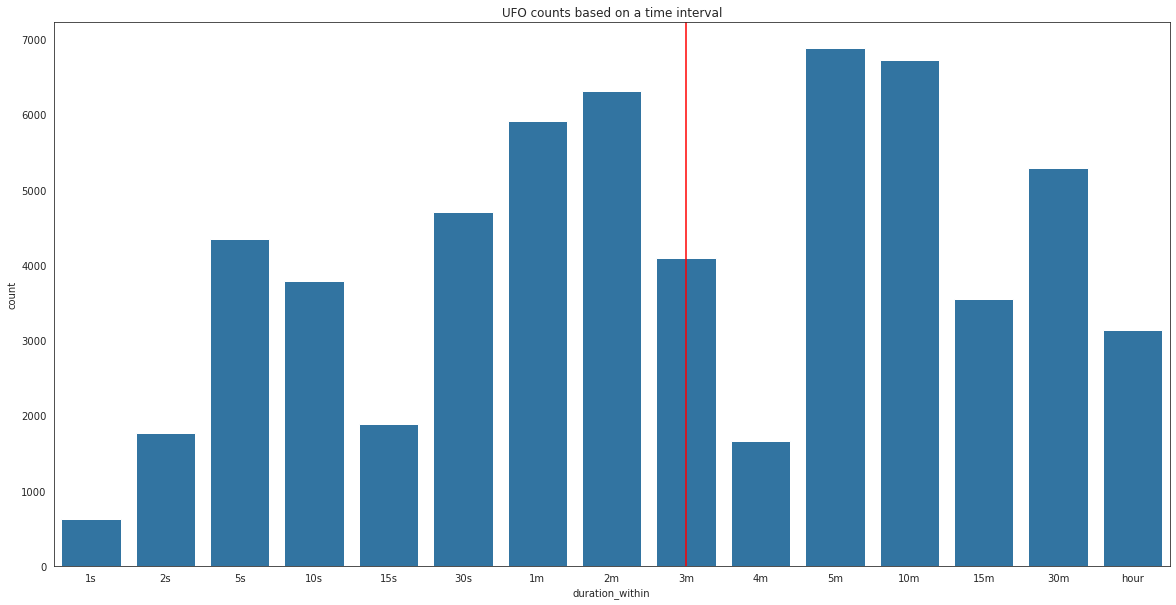

In [68]:
filtered_duration = duration_order[:-3]

fig, ax = plt.subplots(figsize = [20,10])
sns.countplot(data=ufo_1hr_df, x = 'duration_within', color = default_color, order = filtered_duration)
plt.xticks(list(range(0,len(filtered_duration))), filtered_duration)
plt.title('UFO counts based on a time interval')
plt.axvline(8, c='red')
plt.show()

Remembering the median is 180s or 3min, what can we draw from this?

If a person was lying in an open field with low grass to prevent obstruction, how long could they potentially view an aircraft in the vision exactly from left to right (or right to left)? 

image

120 degrees is a person's field of vision (FOV) from left to right if they look straight ahead. So, in this case, a person is looking striaght up from the ground and registering an object from periphery and through the "area of focus" into periphery while keeping their eyes fixed straight up. 

By today's standards, a typical passenger jet flies about 550mph at an altitude of around 7 miles. We need to find the arc length of the top of a cone (the plane travels the arc of the Earth) and calculate how long the jet will pass. Considering 7 miles is perpendicular to the ground and the beginning of the jet's journey into our periphery is the top of a 90 degree triangle, we need find the length of the hypotenuse to use for the radius of our cone, which is simply, 

$$r = \frac{7 \text{ mi}}{sin(30^{\circ})} = 14 \text{ mi}$$

so that

$$L_{arc} = \frac{\theta \pi r}{180} = \frac{120^{\circ}}{180^{\circ}}\cdot\pi\cdot 14 \text{ mi} \approx 29.32 \text{ mi}$$

Then:

$$t_{travel} = \frac{29.32 \text{ mi}}{550 \text{ mi}}\cdot 60 \text{ m} \approx 3.2 \text{ m}$$

Interestingly enough, that is roughly the median of our durations. So, it could be said that this is a baseline on how to gauge durations. Longer durations could mean something moving very slowly (blimp, far-away helicopter or a propellor-driven plane) or seemingly sitting still. Of course, UFOs of strange qualities have been said to hang in the air and suddenly disappear.  If there's anything to take from this graph is that there is at least a three-modal graph with peaks at 5s, 2min, and 5-10min possibly indicating the different "kinds" of sightings. Without more dimension, it's hard to say how to focus on each group and dissect them. Let's at least try grouping them to see what may come of it.

In [69]:
groups = []
for duration_within in ufo_1hr_df['duration_within']:
    if duration_within in ['1s', '2s', '5s', '10s', '15s']:
        groups.append('1-15s')
    elif duration_within in ['30s', '1m', '2m', '3m', '4m']:
        groups.append('30s-4m')
    elif duration_within in ['5m', '10m']:
        groups.append('5-10m')
    else:
        groups.append('15m-1hr')
        
ufo_df.insert(11, 'duration_groups', np.nan, True)
ufo_1hr_df['duration_groups'] = groups
ufo_1hr_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


datetime decade  year  month  hour  dayofweek        city state  \
0 1949-10-10 20:30:00   194X  1949     10    20     Monday  San Marcos    TX   
1 1956-10-10 21:00:00   195X  1956     10    21  Wednesday        Edna    TX   
2 1960-10-10 20:00:00   196X  1960     10    20     Monday     Kaneohe    HI   
3 1961-10-10 19:00:00   196X  1961     10    19    Tuesday     Bristol    TN   
4 1965-10-10 23:45:00   196X  1965     10    23     Sunday     Norwalk    CT   

  military_presence        shape  duration_seconds duration_within  \
0                 Y  Cylindrical            2700.0            hour   
1                 Y      Discoid              20.0             30s   
2                 Y    Lightform             900.0             15m   
3                 Y    Spherical             300.0              5m   
4                 N      Discoid            1200.0             30m   

                                            comments duration_groups  
0  This event took place in early fall around 194...         15m-1hr  
1  My older brother and twin sister were leaving ...          30s-4m  
2  AS a Marine 1st Lt. flying an FJ4B fighter/att...         15m-1hr  
3  My father is now 89 my brother 52 the girl wit...           5-10m  
4  A bright orange color changing to reddish colo...         15m-1hr

In [70]:
duration_groups_order = ['1-15s','30s-4m','5-10m','15m-1hr']

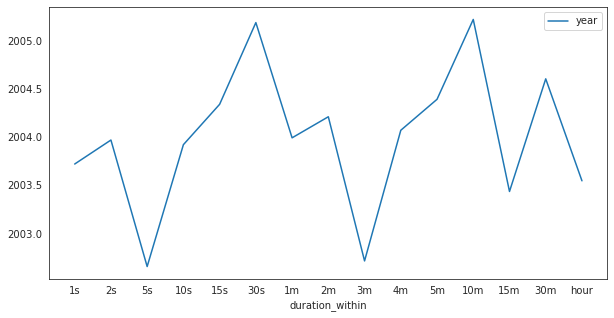

In [71]:
fig, ax = plt.subplots(figsize = [10,5])
ufo_1hr_df[['year','duration_within']].groupby(['duration_within']).mean().plot(kind='line', ax=ax)
plt.xticks(list(range(0,len(filtered_duration))), filtered_duration)
plt.show()

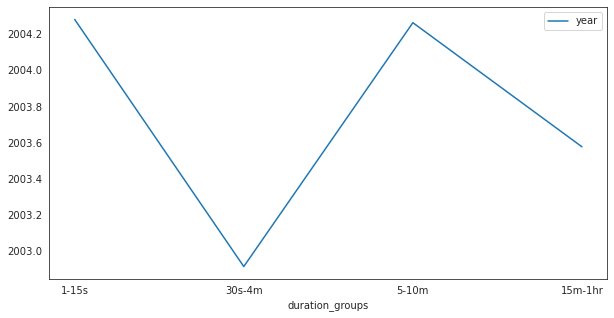

In [72]:
fig, ax = plt.subplots(figsize = [10,5])
ufo_1hr_df[['year','duration_groups']].groupby(['duration_groups']).mean().plot(kind='line', ax=ax)
plt.xticks(list(range(0,len(duration_groups_order))), duration_groups_order)
plt.show()

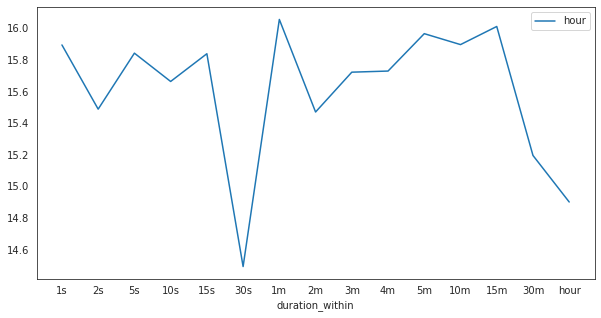

In [73]:
fig, ax = plt.subplots(figsize = [10,5])
ufo_1hr_df[['hour','duration_within']].groupby(['duration_within']).mean().plot(kind='line', ax=ax)
plt.xticks(list(range(0,len(filtered_duration))), filtered_duration)
plt.show()

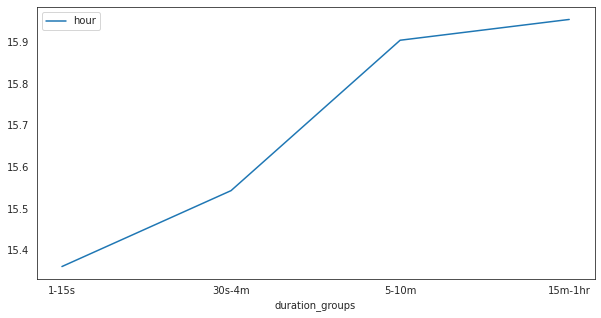

In [74]:
fig, ax = plt.subplots(figsize = [10,5])
ufo_1hr_df[['hour','duration_groups']].groupby(['duration_groups']).mean().plot(kind='line', ax=ax)
plt.xticks(list(range(0,len(duration_groups_order))), duration_groups_order)
plt.show()

I was afraid this might be the case. It's difficult to find a pattern like this. The aim here is to find if length of duration corresponds to technological advancement and speeds of craft. (Do we see quicker times in the present than the past?) Or to find if durations relate to time of day if daylight or night-time affect how long something is seen. Let's try box-and-whiskers.

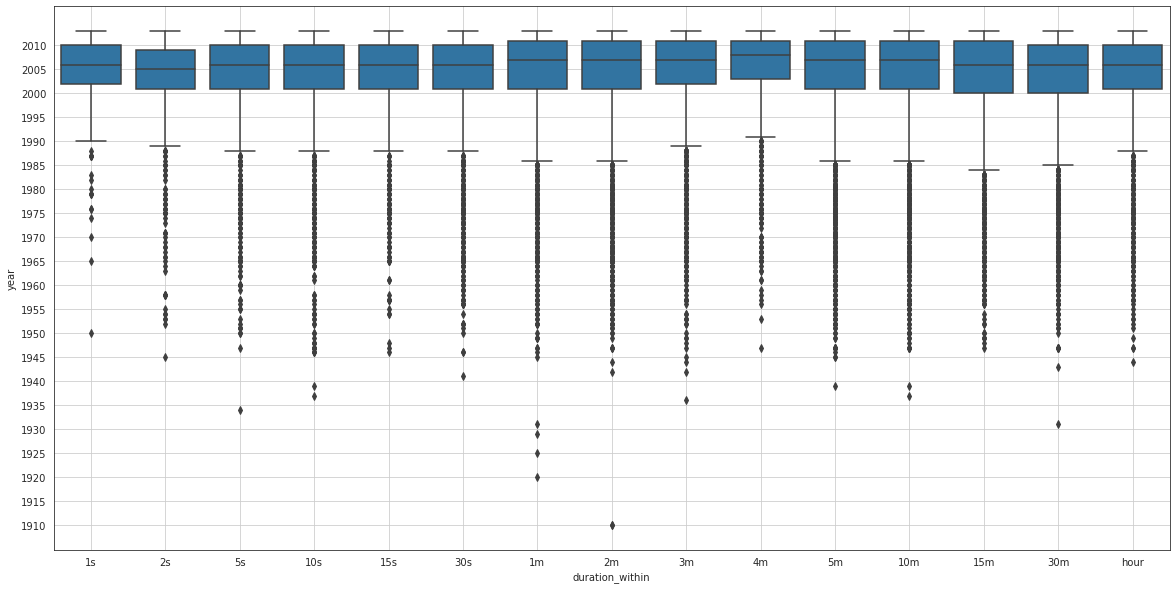

In [75]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_1hr_df, x = 'duration_within', y = 'year', color = default_color, order = filtered_duration)
plt.yticks(list(range(1910,2011,5)))
plt.grid(True)
plt.show()

This is a little interesting as the 1s and 4m durations lean more to the present than other durations with the shortest spread. However, medians reflect more present-day sightings in the 2 to 10m durations - 3m and 4m durations have the shortest spread of these.

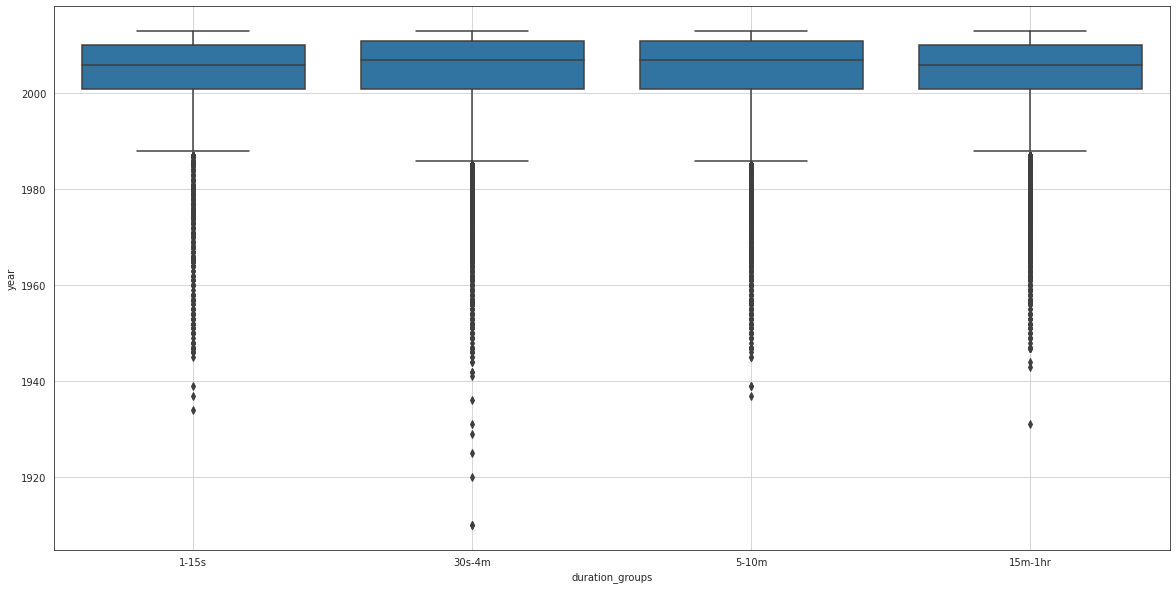

In [76]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_1hr_df, x = 'duration_groups', y = 'year', color = default_color, order = duration_groups_order)
plt.grid(True)
plt.show()

This grouping does not seem to help us here.

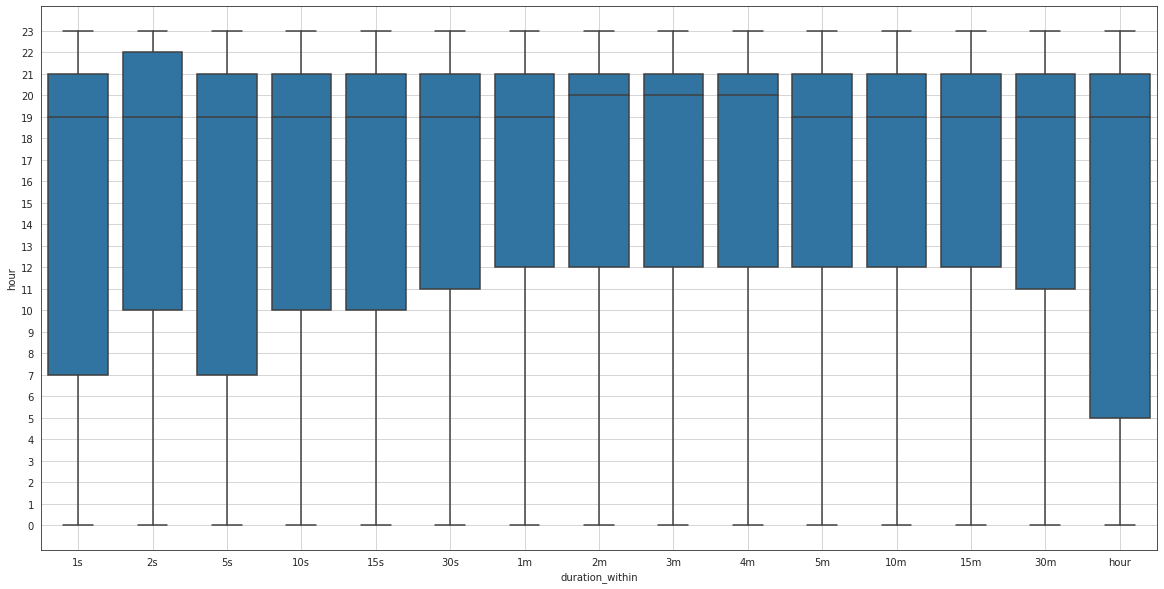

In [77]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_1hr_df, x = 'duration_within', y = 'hour', color = default_color, order = filtered_duration)
plt.yticks(list(range(0,24)))
plt.grid(True)
plt.show()

Very interesting. 1s, 2s, 5s, and 1hr durations seem to cover a majority of the day. Almost all have a median of 7PM, except for 2-4m durations which are an hour later.

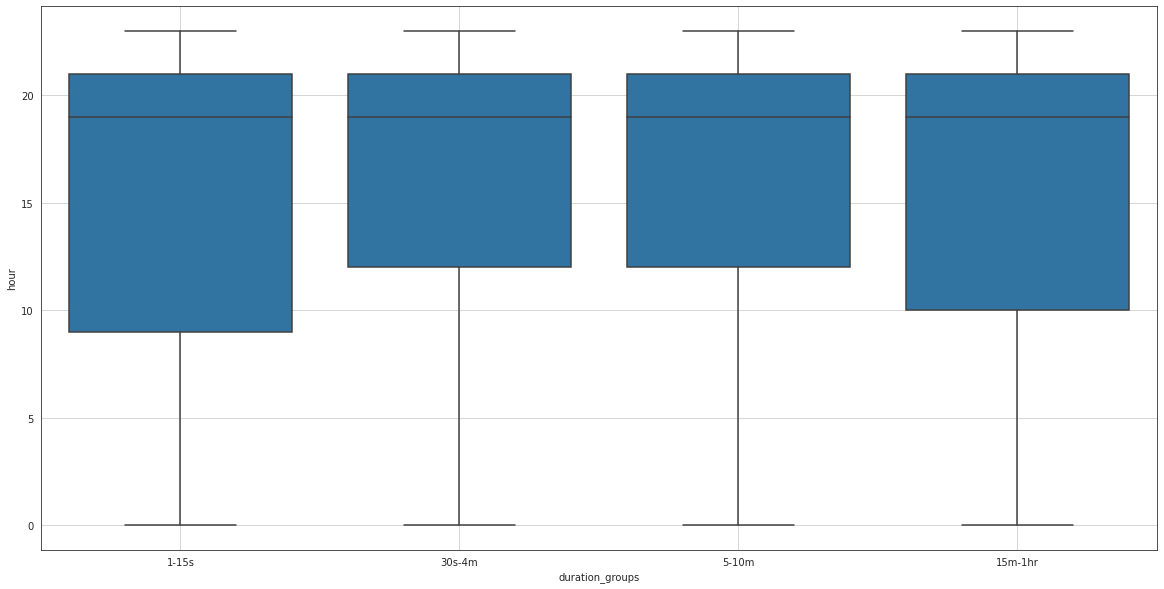

In [78]:
plt.figure(figsize=[20, 10])
sns.boxplot(data = ufo_1hr_df, x = 'duration_groups', y = 'hour', color = default_color, order = duration_groups_order)
plt.grid(True)
plt.show()

Again, not very helpful here.

It is difficult to really pinpoint particular signatures of a genuine UFO sighting with the data I've been reviewing so far. Perhaps let's turn to the unstructured part of our data to see if there's anything interesting that *could* be telling.

In [79]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

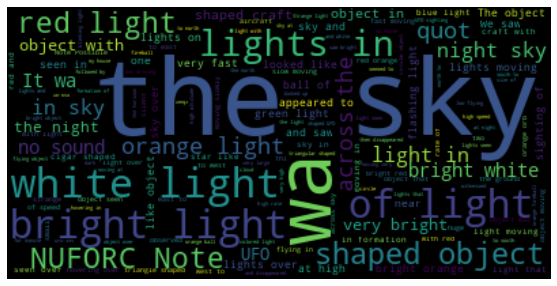

In [80]:
all_text = " ".join(str(comment) for comment in ufo_df['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(all_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"NUFORC" means "National UFO Reporting Center," www.nuforc.org

I will try to filter some of this.

In [81]:
stopwords = set(STOPWORDS)
stopwords.update(["NUFORC", "Note", "quot", "wa"])

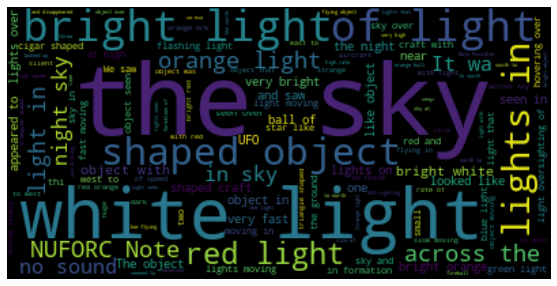

In [82]:
_1hr_text = " ".join(str(comment) for comment in ufo_1hr_df['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_1hr_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Roughly the same emphasis as the main set.

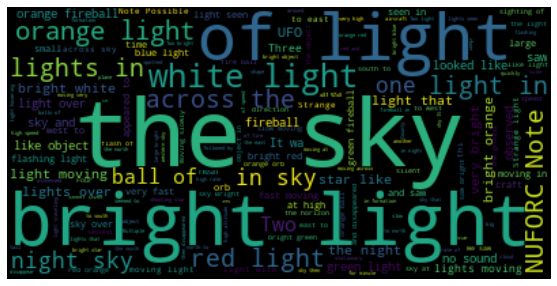

In [83]:
lightform_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['shape']=='Lightform']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(lightform_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Good to see many references to "light."

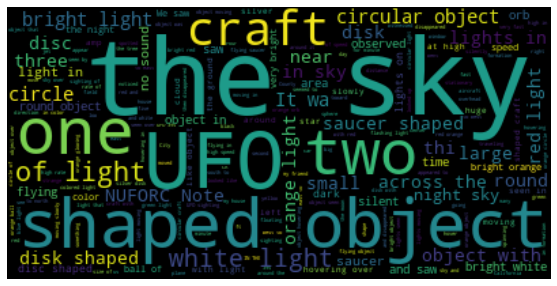

In [84]:
discoid_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['shape']=='Discoid']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(discoid_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"UFO" is emphasized along with any disc-like object.

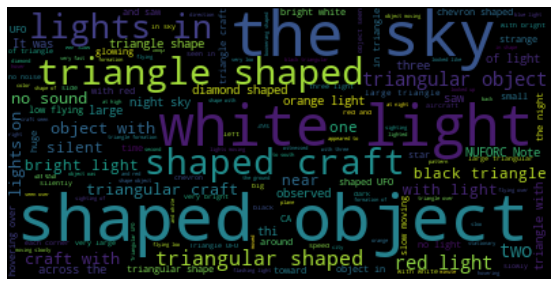

In [85]:
triangular_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['shape']=='Triangular']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(triangular_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

As expected with triangular shapes. Nothing stands out otherwise.

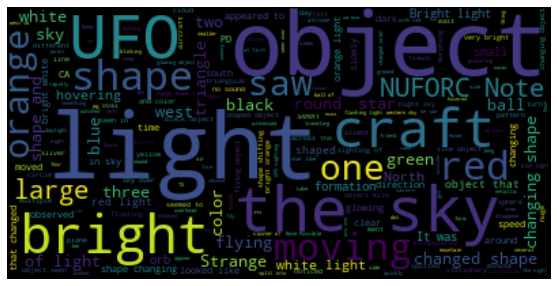

In [86]:
shapeshifter_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['shape']=='Shape-Shifter']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(shapeshifter_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Definitely mixed results here.

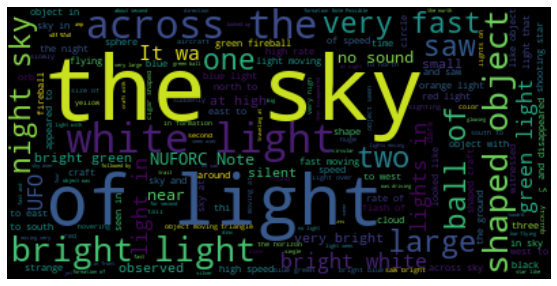

In [87]:
duration1_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_groups']=='1-15s']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration1_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"Very fast," good to see with a small time duration. Not much else, though.

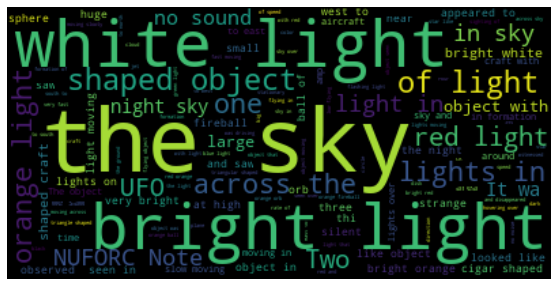

In [88]:
duration2_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_groups']=='30s-4m']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration2_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is looking very similar to all of the 1hr set.

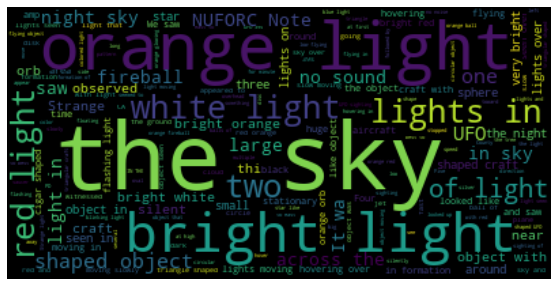

In [89]:
duration3_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_groups']=='5-10m']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration3_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This contains more light references, especially orange.

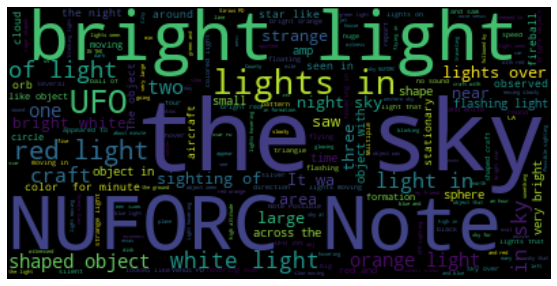

In [90]:
duration4_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_groups']=='15m-1hr']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration4_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

I'm rather mixed about this one. "NUFORC Note" seems spotty to get rid of...

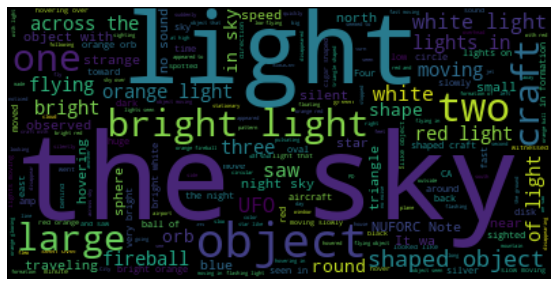

In [91]:
duration_median_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_within']=='3m']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration_median_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Clearly, an "average" activity with this being the median time frame. More emphsis on light objects.

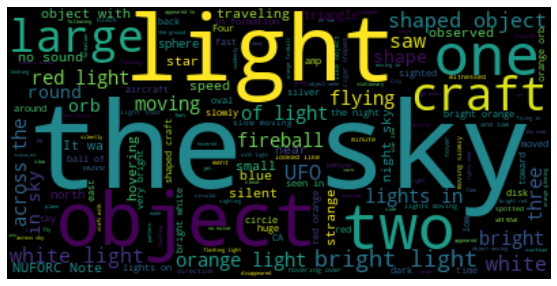

In [92]:
duration_1s_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_within']=='1s']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration_median_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Looking at the utmost smallest interval, it looks very similar to the median time, 180s or 3min. 

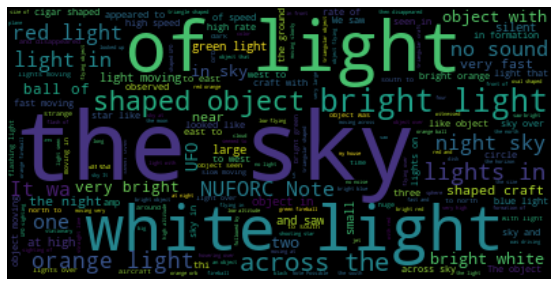

In [93]:
duration_range1_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['duration_seconds']<=180]['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(duration_range1_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Nothing really standing out differently than what we've seen so far.

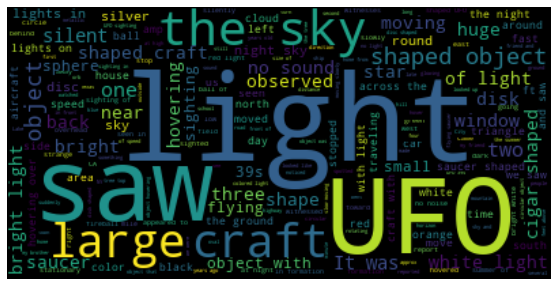

In [94]:
_1910_1989_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['year']<=1989]['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_1910_1989_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"UFO" definitely stands out before 1990, but so does "light." Refering to "silent" or "no sound" is interesting, especially shapes like cigar and saucer.

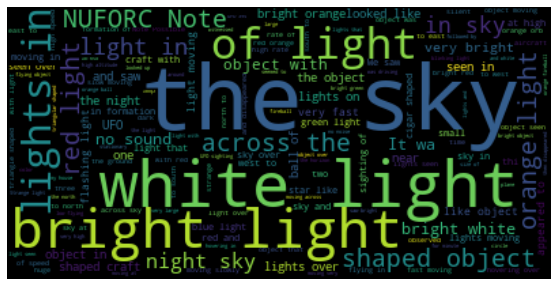

In [95]:
_1990_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['year']>1989]['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_1990_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Very different picture post-1990 with many variations of light.

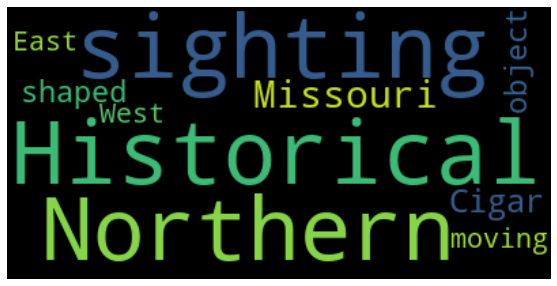

In [96]:
_191X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='191X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_191X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Of course, there aren't many data points for this decade, but neat to see anyway. 

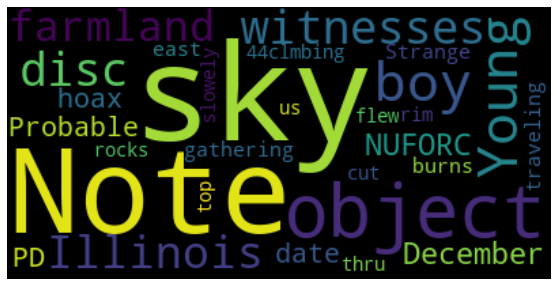

In [97]:
_192X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='192X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_192X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Getting into some country life here with "farmland" coming up. Curious that "hoax" is in this. However, this decade also has few data points.

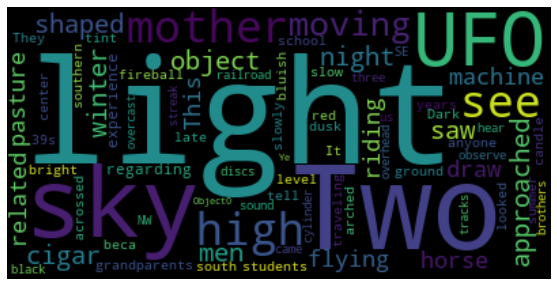

In [98]:
_193X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='193X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_193X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"Railroad, machine, horse, pasture, cigar, candle" are definitely more rural words.  

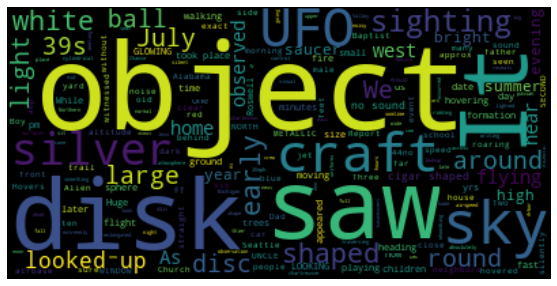

In [99]:
_194X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='194X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_194X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Very different now. "Silver" and "white" are coming into the picture. A lot of disk or round references, especially "UFO" and "saucer."

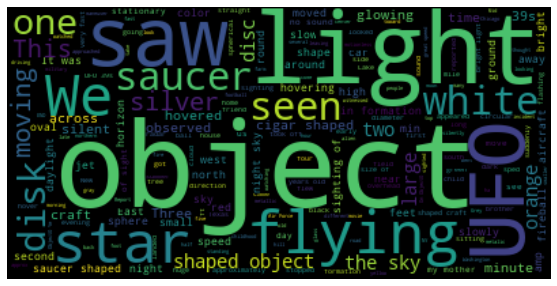

In [100]:
_195X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='195X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_195X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"Silver" and "white" still appear, but also "star."

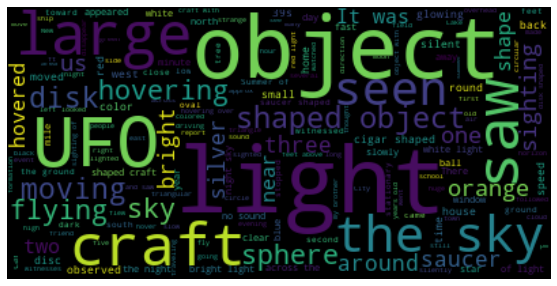

In [101]:
_196X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='196X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_196X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Getting into the 60s, we see "glowing" and "bright" or "sphere" or a more pronounced "large."

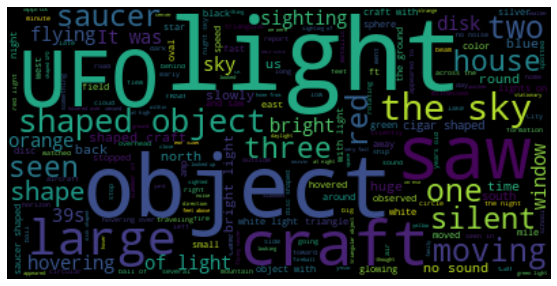

In [102]:
_197X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='197X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_197X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"Red" and "house" are emphasized in the 70s with everything else we've seen.

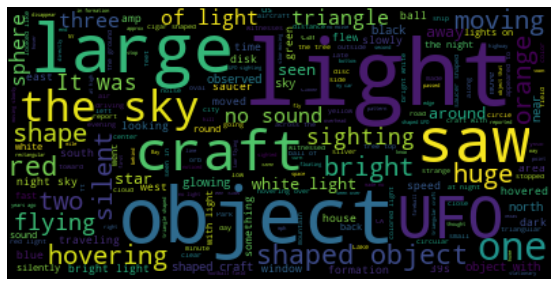

In [103]:
_198X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='198X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_198X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

"Triangle" is showing up in the 80s.

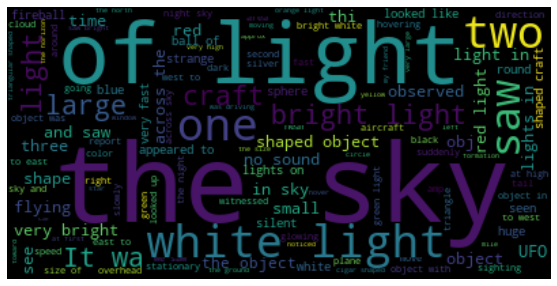

In [104]:
_199X_text = " ".join(str(comment) for comment in ufo_1hr_df[ufo_1hr_df['decade']=='199X']['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(_199X_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Lot's of light, which is getting into the pattern of post-1990 from earlier.

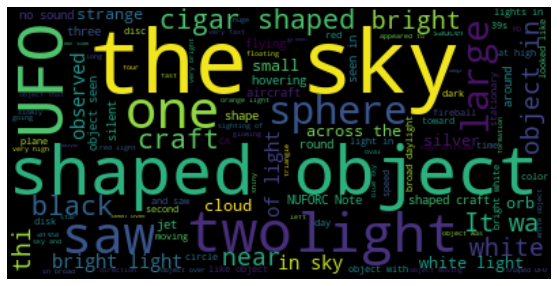

In [105]:
day_text = " ".join(str(comment) for comment in ufo_1hr_df[(ufo_1hr_df['hour']>=7) & (ufo_1hr_df['hour']<=16)]['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(day_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

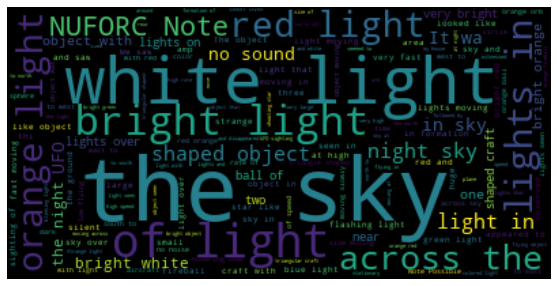

In [107]:
night_text = " ".join(str(comment) for comment in ufo_1hr_df[(ufo_1hr_df['hour']<6) | (ufo_1hr_df['hour']>20)]['comments'])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(night_text)

# Display the generated image:
plt.figure(figsize=[10,5])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

I see a lot of potential using comments and think it is it's own well of analysis. For example, if I go back and make a column for day/night and then look through the decades or individual years, are there periods where more nighttime sightings were seen or daytime? Is there a skewness in decades? Can that be telling of something? Will the comments change after finding particular points in time to review? Maybe the technological traffic of a decade from military development during the Cold War could be telling. Maybe civil air travel increasing could be telling. 

Due to time, I'm going to have to stop this and produce a report and move on. However, personally, I think this is a fascinating example of trying to find patterns in a noisy data set. It would be nice to take specific historical sightings and see what aspects to them make them genuine events that are shrouded with currently unanswerable questions. The whole aim is to determine out of this data set, what is noise and what is a potential phenomenon whether or not it's "alien activity" or not.

In [ ]:
# ''' Plots selected earthquake data on the map of the world '''
 
# import os
# import argparse
# import pandas as pd
# import matplotlib.pyplot as plt
# from mpl_toolkits.basemap import Basemap
# import numpy as np
# import gmplot
 
# class UFOSighting(object):
# ''' Class storing & manipulating earthquake data '''
 
# def __init__(self):
# self.latitude = []
# self.longitude = []
# self.minLatitude = 0.0
# self.maxLatitude = 0.0
# self.minLongitude = 0.0
# self.maxLongitude = 0.0
# self.midLatitude = 0.0
# self.midLongitude = 0.0
# self.date = ''
# self.magnitude = 0.0
# self.map = Basemap()
 
# def ReadAndGetData(self, filename):
# '''
# Reads the data file downloaded from the USGS site and filters as necessary
# (e.g. only accept earthquakes with magnitude greater than 5 etc)
# '''
 
# # Use pandas to get the USGS data content
# df = pd.read_csv(filename) # e.g. filename: USGS_americas_1950_2017_over6.csv
 
# # Use hardcoded min/max Longitude/Latitude for the specific map output
# # One can also use other min/max values (up to the user)
# self.minLongitude, self.maxLongitude = (18.81, 51.327)
# self.minLatitude, self.maxLatitude = (29.155, 47.883)
 
# # Filter data & get only thos larget than 5.0 magnitude
# minMagnitudeDesired = 5.0
 
# filteredDf = df[(df['latitude'] >= self.minLatitude) &
# (df['latitude'] <= self.maxLatitude) & (df['longitude'] >= self.minLongitude - 3.4) &
# (df['longitude'] <= self.maxLongitude - 0.7) & (df['mag'] >= minMagnitudeDesired)]
 
# filteredDf = df
 
# # Filtered data is in panda dataframe format, use df.values.tolist() to convert to list
# #self.latitude = df.latitude # Unfiltered
# #self.longitude = df.longitude
# self.latitude = (filteredDf.latitude).values.tolist()
# self.longitude = (filteredDf.longitude).values.tolist()
# self.date = (filteredDf.time).values.tolist()
# self.magnitude = (filteredDf.mag).values.tolist()
 
# # If you don't want filtering, then min/max can be obtained from the read data
# #self.minLongitude = min(self.longitude)
# #self.maxLongitude = max(self.longitude)
# #self.minLatitude = min(self.latitude)
# #self.maxLatitude = max(self.latitude)
 
# # Calculate mid-point for longitudes and latitudes to center the map upon
# self.midLatitude = 0.5*(self.maxLatitude + self.minLatitude)
# self.midLongitude = 0.5*(self.maxLongitude + self.minLongitude)
 
# print "Quake info: \n", self.__str__()
 
# def DrawMap(self):
# ''' Draw the main background map where the earthquake data will be overlayed
 
# Some other options to check for:
# self.map = Basemap(resolution='h', # c(crude), l(low), i)intermediate), h(high), f(full) or None
# projection='merc', # 'ortho', 'gnom', 'mill'
# lat_0=40.320373, lon_0=-74.43,
# llcrnrlon=minLon, llcrnrlat= minLat, urcrnrlon=maxLon, urcrnrlat=maxLat )
 
# # It is also possible to download arcgis images through the following command
# self.map.arcgisimage(service='World_Physical_Map', xpixels = 5000, verbose= False)
# '''
 
# fig, ax = plt.subplots(figsize=(16, 9))
# fig.patch.set_facecolor('white') # Set white background
 
# self.map = Basemap(height=1.7e6, width=2.8e6,
# resolution='f', area_thresh=10., projection='omerc',
# lon_0=self.midLongitude, lat_0=self.midLatitude,
# lon_1=self.minLongitude, lat_1=self.minLatitude,
# lon_2=self.maxLongitude, lat_2=self.maxLatitude)
 
# self.map.drawmapboundary(fill_color='#46bcec')
# self.map.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
# self.map.drawcounties()
# self.map.drawcountries(linewidth=0.25)
 
# self.map.drawcoastlines()
 
# self.map.drawparallels(np.arange(self.minLatitude, self.maxLatitude, 10.))
# self.map.drawmeridians(np.arange(self.minLongitude, self.maxLongitude, 10.))
 
# plt.tight_layout()
 
# return
 
# def PlotEarthquakeLocationsOnMap(self, bPlotPoints):
# ''' Just plot the points where the earthquake occurred '''
 
# if bPlotPoints:
# # Default size for already displayed points (in a time-lapse fashion, some points
# # have already been displayed as shrinking points - at this stage only show shrunk versions)
# pstart = ARGS.npoints - ARGS.nsimpoints
# pend = ARGS.npoints
# x, y = self.map(self.longitude[0:pstart], self.latitude[0:pstart])
# self.map.plot(x, y, 'ro', alpha=0.8, markersize=5, markeredgecolor='red',
# fillstyle='full', markeredgewidth=0.1)
 
# # Custom (most of the time bigger) font for the new point to be displayed
# x, y = self.map(self.longitude[pstart:pend], self.latitude[pstart:pend])
# self.map.plot(x, y, 'ro', alpha=0.8, markersize=65-ARGS.markersize, markeredgecolor='red',
# fillstyle='full', markeredgewidth=0.1)
 
# day = (self.date[ARGS.npoints].split('T'))[0]
# magnitude = self.magnitude[pend]
# plt.title('Earthquake on {} - magnitude {}'.format(day, magnitude))
 
# return
 
# def WriteCityNamesOnTheMap(self):
# '''
# Write names of selected cities on the map after finding
# their corresponding latitude/longitude value
# '''
 
# # Lat/lon coordinates of several cities that lie in the map of interest
# lats = [41.00, 41.71, 35.12, 35.24, 37.04, 37.26, 39.90,
# 44.42, 44.78, 41.32, 36.89, 35.46, 31.20, 32.09,
# 43.60, 33.89, 39.93, 42.13, 31.94, 45.04, 36.20,
# 43.85, 41.11, 31.76, 29.87, 44.61, 38.50, 38.35,
# 36.43, 45.65, 42.26, 38.42, 42.83]
 
# lons = [28.97, 44.82, 33.42, 24.80, 22.11, 35.39, 41.26,
# 26.10, 20.44, 19.81, 30.71, 44.38, 29.91, 20.18,
# 39.73, 35.50, 32.85, 24.74, 35.92, 41.96, 37.13,
# 18.41, 16.87, 35.21, 40.10, 33.52, 43.37, 38.33,
# 28.21, 25.60, 42.71, 27.14, 31.70]
 
# cities = ['Istanbul', 'Tblisi', 'Cyprus', 'Crete', 'Kalamata', 'Adana',
# 'Erzurum', 'Bucharest', 'Belgrade', 'Tirana', 'Antalya',
# 'Kerkuk', 'Alexandria', 'Benghazi', 'Sochi', 'Beirut',
# 'Ankara', 'Plovdiv', 'Amman', 'Stavropol', 'Aleppo',
# 'Sarajevo', 'Bari', 'Jerusalem', 'Sakaka', 'Sevastopol',
# 'Van', 'Malatya', 'Rhodes', 'Brasov', 'Kutaisi', 'Izmir',
# 'B L A C K S E A']
 
# # Compute the native map projection coordinates for cities.
# xc, yc = self.map(lons, lats)
 
# # Plot filled circles at the locations of the cities.
# self.map.plot(xc[:-1], yc[:-1], 'bo')
 
# # Some certain city names need to be shifted for better visualization
# for name, xpt, ypt in zip(cities, xc, yc):
# if name == 'Alexandria' or name == 'Crete' or name == 'Van' or name == 'Malatya':
# plt.text(xpt+10000, ypt-20000, name, fontsize=9)
# elif name == 'Jerusalem':
# plt.text(xpt-40000, ypt-30000, name, fontsize=9)
# elif name == 'Kalamata':
# plt.text(xpt-30000, ypt+15000, name, fontsize=9)
# elif name == 'Istanbul' or name == 'Benghazi':
# plt.text(xpt+20000, ypt-10000, name, fontsize=9)
# elif name == 'B L A C K S E A':
# plt.text(xpt+15000, ypt+10000, name, fontsize=11)
# else:
# plt.text(xpt+10000, ypt+10000, name, fontsize=9) # Default visualization
 
# return
 
# def UseGMPLOTtoDumptoGoogleMap(self, htmlfilename):
# ''' Convert the same earthquake data info to Google Map heat map format
# NOTE: gmplot package needs to be pre-installed
 
# # Some other options using gmplot
# gmap.plot(latitudes, longitudes, 'cornflowerblue', edge_width=10)
# gmap.plot(latitudes, longitudes, 'red', edge_width=8)
# gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
# gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
# gmap.scatter(lat, lon, 'r', size=10, marker=False)
# '''
 
# gmap = gmplot.GoogleMapPlotter(self.midLatitude, self.midLongitude, 3) # lat/lon/google map zoom level
 
# gmap.heatmap(self.latitude, self.longitude)
 
# gmap.draw(htmlfilename)
 
# return
 
# def SaveSnapshotsToFile(self, bSaveFigs=True, snapshotfilename='earthquakes_dpi240'):
# '''
# Save the earthquake snapshots in time to file
# Note that for (16,9) sized figure, dpi=120 gives (16,9)*120 =[1920,1080] pixels png file
# Similarly, dpi=240 gives (16,9)*240 =[3840,2160] pixels png file
# '''
 
# if bSaveFigs:
# OutFolder = 'Snapshots_{}'.format(ARGS.npoints - ARGS.npoints%100)
# if not os.path.exists(OutFolder):
# os.mkdir(OutFolder)
 
# outpngfilename = '{}/{}_{}_{}.png'.format(OutFolder, snapshotfilename,
# ARGS.npoints, ARGS.markersize)
# plt.savefig(outpngfilename, facecolor='w', dpi=240)
# else:
# plt.show()
 
# return
 
# def __str__(self):
# ''' Print some data on the earthquake class'''
 
# str1 = "Number of points = {}".format(len(self.longitude))
# str2 = "Latitude (min,max) = {}, {}".format(self.minLatitude, self.maxLatitude)
# str3 = "Longitude (min,max) = {}, {}".format(self.minLongitude, self.maxLongitude)
# str4 = "Mid points (Longitude, Langitude)= {}, {}".format(self.midLongitude, self.midLatitude)
 
# return '{}\n{}\n{}\n{}\n'.format(str1, str2, str3, str4)
 
# def ParseInput():
# ''' Parse input arguments '''
 
# parser = argparse.ArgumentParser()
 
# parser.add_argument("-markersize", type=float, default=5, help="Marker size to represent the earthquake data on the map")
# parser.add_argument("-npoints", type=int, default=1, help="Total number of points in the graph [sweep the whole range for final video output]")
# parser.add_argument("-nsimpoints", type=int, default=1, help="Number of simultaneous points having different marker size")
# parser.add_argument("-usgsdata", type=str, help="Filename (e.g. usgs.csv) that contains the earthquake data as downloaded from USGS")
 
# args = parser.parse_args()
 
# return args
 
# def main():
 
# quake = EarthquakeData();
# quake.ReadAndGetData(ARGS.usgsdata)
 
# quake.DrawMap()
# quake.WriteCityNamesOnTheMap()
# quake.PlotEarthquakeLocationsOnMap(True)
# quake.SaveSnapshotsToFile(True)
 
# # This is a bonus feature - dumping the earthquake heatmap to google maps format [uses gmplot]
# quake.UseGMPLOTtoDumptoGoogleMap("earthquake_test.html")
 
# if __name__ == '__main__': # standard boilerplate calling main()
# ARGS = ParseInput()
# main()

In [ ]:
# # 1. Draw the map background
# fig = plt.figure(figsize=(8, 8))
# m = Basemap(projection='lcc', resolution='h', 
#             lat_0=37.5, lon_0=-119,
#             width=1E6, height=1.2E6)
# m.shadedrelief()
# m.drawcoastlines(color='gray')
# m.drawcountries(color='gray')
# m.drawstates(color='gray')

# # 2. scatter city data, with color reflecting population
# # and size reflecting area
# m.scatter(lon, lat, latlon=True,
#           c=np.log10(population), s=area,
#           cmap='Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm population})$')
# plt.clim(3, 7)

# # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');




# fig = plt.figure(figsize=(10, 8))
# m = Basemap(projection='lcc', resolution='c',
#             width=8E6, height=8E6, 
#              lat_0=45, lon_0=-100,)
# m.shadedrelief(scale=0.5)
# m.pcolormesh(lon, lat, temp_anomaly,
#              latlon=True, cmap='RdBu_r')
# plt.clim(-8, 8)
# m.drawcoastlines(color='lightgray')

# plt.title('January 2014 Temperature Anomaly')
# plt.colorbar(label='temperature anomaly (°C)');

In [ ]:
# # Hawaii has 8 main islands but several tiny atolls that extend for many miles.
# # This is the area cutoff between the 8 main islands and the tiny atolls.
# ATOLL_CUTOFF = 0.005

# m = Basemap(llcrnrlon=-121,llcrnrlat=20,urcrnrlon=-62,urcrnrlat=51,
#     projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

# # load the shapefile, use the name 'states'
# m.readshapefile('st99_d00', name='states', drawbounds=True)

# ax = plt.gca()


# for i, shapedict in enumerate(m.states_info):
#     # Translate the noncontiguous states:
#     if shapedict['NAME'] in ['Alaska', 'Hawaii']:
#         seg = m.states[int(shapedict['SHAPENUM'] - 1)]
#         # Only include the 8 main islands of Hawaii so that we don't put dots in the western states.
#         if shapedict['NAME'] == 'Hawaii' and float(shapedict['AREA']) > ATOLL_CUTOFF:
#             seg = list(map(lambda (x,y): (x + 5200000, y-1400000), seg))
#         # Alaska is large. Rescale it.
#         elif shapedict['NAME'] == 'Alaska':
#             seg = list(map(lambda (x,y): (0.35*x + 1100000, 0.35*y-1300000), seg))
#         poly = Polygon(seg, facecolor='white', edgecolor='black', linewidth=.5)
#         ax.add_patch(poly)

https://meyavuz.wordpress.com/2017/04/30/how-to-make-time-lapse-animation-of-earthquakes-with-python/
https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html
https://stackoverflow.com/questions/39742305/how-to-use-basemap-python-to-plot-us-with-50-states